In [1]:
## -- Check for 3rd party libraries (tpu) --
try:
    import xgboost as xgb
except:
    %pip install -q xgboost
    import xgboost as xgb

In [2]:
!pip show xgboost

Name: xgboost
Version: 3.1.0
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: TPOT


In [3]:
## -- System dependencies --
import sys, os, gc
import torch

## -- Device-Agnostic for GPU --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
    # get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    # get_ipython().run_line_magic('load_ext', 'cuml.accel')
    # from cuml.preprocessing import TargetEncoder as cuTE
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")

ℹ️ Device GPU: Tesla P100-PCIE-16GB
ℹ️ No. of CPU: 4 cores


In [4]:
## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

## -- Functional Tools --
from time import time, sleep
from tqdm.notebook import tqdm
import itertools

## -- Machine Learning --
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

import warnings

In [5]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
sns.set_style("whitegrid")
# plt.style.use("ggplot")

PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [6]:
## -- Load Data --

PATH = '/kaggle/input/competitions/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()

ORIG_PATH = '/kaggle/input/datasets/sylvesterdalmeida/myheart-disease-dataset/'
# ORIG_PATH = '/kaggle/input/datasets/neurocipher/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

for df in [train, orig]:
    df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [7]:
display(train.head())
train.info()

Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   58    1                4  152          239             0            0   
1   52    1                1  125          325             0            2   
2   56    0                2  160          188             0            2   
3   44    0                3  134          229             0            2   
4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium  Heart Disease  
0                        2         7              1  
1                        0         3              0  
2                        0         3              0  
3                        0         3              0  
4                        3         3              1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: f

In [8]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in BASE:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient()

## FEATURE ENGINEERING

In [9]:
# ## -- Factorize using combined data --
# for c in CATS:
#     combine  = pd.concat([train[c], test[c], orig[c]])
#     combine  = combine.factorize()[0]
#     train[c] = combine[:len(train)]
#     test[c]  = combine[len(train):len(train)+len(test)]
#     orig[c]  = combine[-len(orig):]

# ## -- Treat age(8 unique values) as category --
# NUMS.remove('age')
# CATS.append('age')

# print('Label encoding complete!')

In [10]:
# ## -- Append predicted columns as extra features --
# ## -- os.walk: Deep search with subfolders --
# def dataloader(filepath):    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
    
#     # print("Loading .npy: ", end="")
#     # for (root, dirs, files) in os.walk(filepath):
#     #     for i, file in enumerate(sorted(files), 1):
#     #         if i%5 == 0: print(f"{i}%.. ", end="")
#     #         if file.endswith(".npy") and "train" in file:
#     #             train_path = np.load(os.path.join(root, file))
#     #             train = pd.concat([train, pd.Series(train_path, name=file[6:-4])], axis=1)
#     #         elif file.endswith(".npy") and "test" in file:
#     #             test_path = np.load(os.path.join(root, file))
#     #             test = pd.concat([test, pd.Series(test_path, name=file[5:-4])], axis=1)
#     # print()
#     print("Loading .parquet files: ", end="")
#     for (root, dirs, files) in os.walk(filepath):
#         for i, file in enumerate(sorted(files), 1):
#             if i%5 == 0: print(f"{i}%.. ", end="")
#             if file.endswith(".parquet") and "train" in file:
#                 train_path = os.path.join(root, file)
#                 train_df = pd.concat([train_df, pd.read_parquet(train_path)], axis=1)
#             elif file.endswith(".parquet") and "test" in file:
#                 test_path = os.path.join(root, file)
#                 test_df = pd.concat([test_df, pd.read_parquet(test_path)], axis=1)
#     print()
#     print(f"Total train models: {len(train_df.columns)} || Shape: {train_df.shape}")
#     print(f"Total test models : {len(test_df.columns)} || Shape: {test_df.shape}")
#     print()

#     return train_df, test_df

In [11]:
# PATHS = [
#     # '/kaggle/input/ps6e1-per-feature-ag',
#     '/kaggle/input/ps6e1-autogluon-trainorig',
#     # '/kaggle/input/ps6e1-lr-gbdt-nn-trainorig',
# ]

# ## -- Load dataframes --
# train_dfs = []
# test_dfs  = []

# ## -- Load train/test datasets --
# for p in PATHS:
#     tr, ts = dataloader(p)
#     train_dfs.append(tr)
#     test_dfs.append(ts)

# ## -- Concat datasets --
# ext_train = pd.concat(train_dfs, axis=1)
# ext_test  = pd.concat(test_dfs, axis=1)

# print('External data loaded', ext_train.shape, ext_test.shape)

# ## -- Drop weighted autogluon models --
# for c in ext_train.columns:
#     if 'L2' in c or 'L3' in c: # 
#         ext_train.drop([c], axis=1, inplace=True)
#         ext_test.drop([c], axis=1, inplace=True)
#     elif c == TARGET:
#         ext_train.drop([c], axis=1, inplace=True)
    
# ## -- Check for missing values --
# print('Check missingness:', ext_train.isna().sum().sum(), ext_test.isna().sum().sum())

# display(ext_train.head(3))
# display(ext_test.head(3))

In [12]:
# %%time

# plt.figure(figsize=(18, 5))
# ext_train.boxplot()
# # sns.boxplot(ext_train)
# plt.tick_params(axis='x', rotation=90)

In [13]:
# ## -- Merge datasets --
# top_cols = ext_train.columns.tolist()

# train = pd.concat([train, ext_train], axis=1)
# test = pd.concat([test, ext_test], axis=1)

# train.head(3)

In [14]:
# ## -- Create 'meta' feature --
# ## -- https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665915
# def meta_feature(df):
#     formula = (
#         6 * df.study_hours + \
#         0.35 * df.class_attendance + \
#         1.5 * df.sleep_hours + \
#         5 * (df.sleep_quality=='good') + \
#         -5 * (df.sleep_quality=='poor') + \
#         10 * (df.study_method=='coaching') + \
#         5 * (df.study_method=='mixed') + \
#         2 * (df.study_method=='group study') + \
#         1 * (df.study_method=='online videos') + \
#         4 * (df.facility_rating=='high') + \
#         -4 * (df.facility_rating=='low')
#     )
#     return formula

# train['formula'] = meta_feature(train)
# test['formula'] = meta_feature(test)
# orig['formula'] = meta_feature(orig)

# ## -- Set ordinal mapping --
# ordinal_maps = {
#     "internet_access": {"no":0, "yes":1},
#     "gender": {"male":0, "female":1, "other":2},
#     "sleep_quality": {"poor":0, "average":1, "good":2},
#     "facility_rating": {"low":0, "medium":1, "high":2},
#     "exam_difficulty": {"easy":0, "moderate":1, "hard":2},
#     "course": {"ba":0, "b.sc":1, "diploma":2, "b.tech":3, "b.com":4, "bca":5, "bba":6},
#     "study_method": {"self-study":0, "online videos":1, "group study":2, "mixed":3, "coaching":4},
# }

# for c in CATS:
#     train[c] = train[c].map(ordinal_maps[c]).fillna(-1)
#     test[c] = test[c].map(ordinal_maps[c]).fillna(-1)
#     orig[c] = orig[c].map(ordinal_maps[c]).fillna(-1)

# print("Feature 'formula' and ordinal label encoded")

In [15]:
# ## -- Duplicate all features as categories --
# # BINARY_COLS = [ c for c in BASE if train[c].nunique() <= 2]
# CATS_2 = []

# for c in NUMS:
#     n = f"cat_{c}"
#     train[n] = train[c].copy()
#     test[n]  = test[c].copy()
#     orig[n]  = orig[c].copy()
#     CATS_2.append(n)

#     ## -- FACTORIZE CATS_2 --
#     combine  = pd.concat([train[n], test[n], orig[n]])
#     v, _ = combine.factorize()
#     train[n] = v[:len(train)].astype('int32')
#     test[n]  = v[len(train):len(train)+len(test)].astype('int32')
#     orig[n]  = v[len(train)+len(test):].astype('int32')

# print(f'NUMS TO CAT: {len(CATS_2)}')

# train.head(3)

In [16]:
# # DOUBLES = [c for c in BASE if train_df[c].dtype == 'float']
# ROUND = []

# for col in tqdm(TOP_PREDICTORS): # +['formula']
#     for r in range(-2, 4):
#         n = f"{col}_r{r}"
#         train[n] = train[col].round(r).astype('int32')
#         test[n]  = test[col].round(r).astype('int32')
#         orig[n]  = test[col].round(r).astype('int32')

#         ## -- Drop constant features --
#         if train[n].nunique() < 3:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             ROUND.append(n)

# print(f'Total ROUNDed Features: {len(ROUND)}')
# print(train[ROUND].nunique())

In [17]:
# INTER = []

# for c1, c2 in tqdm(list(itertools.combinations(['Age', 'Sex', 'Chest pain type', 'Thallium'], 2)), desc='Pairwise'):
#     n_col = f"{c1}-|-{c2}"
#     train[n_col] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[n_col]  = test[c1].astype(str) + '_' + test[c2].astype(str)
#     orig[n_col]  = orig[c1].astype(str) + '_' + orig[c2].astype(str)
#     INTER.append(n_col)

# for c1, c2, c3 in tqdm(list(combinations(TOP_PREDICTORS+TOP_PREDICTORS_2, 3)), desc='Triplewise'):
#     n_col = f"{c1}-|-{c2}-|-{c3}"
#     train[n_col] = train[c1].astype(str) + '_' + train[c2].astype(str) + '_' + train[c3].astype(str)
#     test[n_col] = test[c1].astype(str) + '_' + test[c2].astype(str) + '_' + test[c3].astype(str)
#     INTER.append(n_col)

# for c1, c2 in tqdm(list(product(TOP_PREDICTORS, OTHER_PREDICTORS)), desc='1-to-many Pairwise'):
#     new_col = f"{c1}-|-{c2}"
#     train[new_col] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[new_col] = test[c1].astype(str) + '_' + test[c2].astype(str)
#     orig[new_col] = orig[c1].astype(str) + '_' + orig[c2].astype(str)
#     INTER.append(new_col)

# print(f"Interaction Features: {len(INTER)}")

In [18]:
## -- Merge original features as columns --
USE_ORIG_COL = False
ORIG = []

if USE_ORIG_COL:
    for col in tqdm(BASE): 
        # MEAN
        mean_col = f"OTE_{col}_mean"
        mean_map = orig.groupby(col)[TARGET].mean().reset_index(name=mean_col)
    
        train = train.merge(mean_map, on=col, how='left')
        test = test.merge(mean_map, on=col, how='left')
        ORIG.append(mean_col)
    
        # COUNT
        count_col = f"OTE_{col}_count"
        count_map = orig.groupby(col).size().reset_index(name=count_col)
    
        train = train.merge(count_map, on=col, how='left')
        test = test.merge(count_map, on=col, how='left')
        ORIG.append(count_col)
    
        # # UNIQUE
        # unique_col = f"OTE_{col}_nunique"
        # unique_map = orig.groupby(col)[TARGET].nunique().reset_index(name=unique_col)
    
        # train = train.merge(unique_map, on=col, how='left')
        # test = test.merge(unique_map, on=col, how='left')
        # ORIG.append(unique_col)
    
        # STD
        std_col = f"OTE_{col}_std"
        std_map = orig.groupby(col)[TARGET].std().reset_index(name=std_col)
    
        train = train.merge(std_map, on=col, how='left')
        test = test.merge(std_map, on=col, how='left')
        ORIG.append(std_col)
    
        # MAX
        max_col = f"OTE_{col}_max"
        max_map = orig.groupby(col)[TARGET].max().reset_index(name=max_col)
    
        train = train.merge(max_map, on=col, how='left')
        test = test.merge(max_map, on=col, how='left')
        ORIG.append(max_col)
    
        # MIN
        min_col = f"OTE_{col}_min"
        min_map = orig.groupby(col)[TARGET].min().reset_index(name=min_col)
    
        train = train.merge(min_map, on=col, how='left')
        test = test.merge(min_map, on=col, how='left')
        ORIG.append(min_col)
    
        # # MEDIAN
        # median_col = f"OTE_{col}_median"
        # median_map = orig.groupby(col)[TARGET].median().reset_index(name=median_col).astype('float32')
    
        # train = train.merge(median_map, on=col, how='left')
        # test = test.merge(median_map, on=col, how='left')
        # ORIG.append(median_col)

# for col in ORIG:
#     if train[col].nunique() < 2:
#         train.drop([col], axis=1, inplace=True)
#         test.drop([col], axis=1, inplace=True)
#         ORIG.remove(col)
#     else:
#         continue

print(len(ORIG), 'Orig Features Created!')

0 Orig Features Created!


In [19]:
## -- Import AutoGluon predictions for XGB's 'base_score' --
USE_BASE = False

if USE_BASE:
    PATH_BASE  = '/kaggle/input/ps6e1-autogluon-trainorig/AG_preds/'
    train_base = pd.read_parquet(PATH_BASE+'train_ag_student_orig.parquet')
    test_base  = pd.read_parquet(PATH_BASE+'test_ag_student_orig.parquet')
                 
    train['base'] = train_base['WeightedEnsembleL2'].astype('float32')
    test['base'] = test_base['WeightedEnsembleL2'].astype('float32')
    
    print("- Use initial base_score: TRUE")
    display(train.head(3))

In [20]:
# ## -- Reduce data memory --
# def reduce_memory(df):
#     old_size = sys.getsizeof(df) / (1024*1024)
#     for c in tqdm(df.columns, desc='Reducing memory...'):
#         ## -- Downcast Integer type ---
#         if df[c].dtype == np.int64: 
#             if df[c].min() > np.iinfo(np.int32).min and df[c].max() < np.iinfo(np.int32).max:
#                 df[c] = df[c].astype(np.int32)
#                 # if df[c].min() > np.iinfo(np.int16).min and df[c].max() < np.iinfo(np.int16).max:
#                 #     df[c] = df[c].astype(np.int16)
#                 #     if df[c].min() > np.iinfo(np.int8).min and df[c].max() < np.iinfo(np.int8).max:
#                 #         df[c] = df[c].astype(np.int8)
#         ## -- Downcast Float type -----
#         # elif df[c].dtype == np.float64:
#         #     if df[c].min() > np.finfo(np.float32).min and df[c].max() < np.finfo(np.float32).max:
#         #         df[c] = df[c].astype(np.float32)
#                 # if df[c].min() > np.finfo(np.float16).min and df[c].max() < np.finfo(np.float16).max:
#                 #     df[c] = df[c].astype(np.float16)

#     new_size = sys.getsizeof(df) / (1024*1024)
#     print(f"Size before process: {old_size:.1f}MB")
#     print(f"Size after process : {new_size:.1f}MB\n")
    
#     return df

# train = reduce_memory(train)
# test = reduce_memory(test)
# orig = reduce_memory(orig)

# gc.collect()

# print(f"Data memory reduced!")

In [21]:
def orig_TE_data_propagate(orig: pd.DataFrame,
                          X_train: pd.DataFrame,
                          X_val: pd.DataFrame,
                          X_test: pd.DataFrame,
                          features: list = None,
                          aggs: list = None,
                          fill_nan: bool = False):
    """
    Improve propagation of engineered features by:
    - Allowing multiple aggregations per feature (e.g., ['mean', 'median']).
    - Reusing per-(col, agg) maps to minimize recomputation.
    - Optional global NaN filling after merges (fill_nan: True/False).
    - Using a consistent NaN-based missing-value strategy (fill later if needed).
    - Maintaining clear dtype management.

    Parameters:
    - fill_nan: If True, fill NaNs in the newly created features with a sentinel value.
      Float features use -1e9, integer features use -1. If downstream needs different
      behavior, we can adjust or apply a separate imputation step later.
    """
    if features is None or len(features) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    if aggs is None or len(aggs) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []

    maps = {}

    valid_features = [col for col in features if col in orig.columns]

    # Optional: decide sentinel depending on dtype later; we assume numeric targets
    SENTINEL_FLOAT = 9e-6
    SENTINEL_INT = -1

    for col in tqdm(valid_features, desc='TE_merging'):
        for agg_ in aggs:
            agg_key = agg_.lower()
            new_col = f"OTE_{col}_{agg_key}"

            map_key = (col, agg_key)
            if map_key not in maps:
                try:
                    if agg_key == 'mean':
                        map_df = (orig.groupby(col)[TARGET]
                                  .mean()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'median':
                        map_df = (orig.groupby(col)[TARGET]
                                  .median()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'count':
                        map_df = (orig.groupby(col).size()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'std':
                        map_df = (orig.groupby(col)[TARGET]
                                  .std()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'skew':
                        map_df = (orig.groupby(col)[TARGET]
                                  .skew()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'nunique':
                        map_df = (orig.groupby(col)[TARGET]
                                  .nunique()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'max':
                        map_df = (orig.groupby(col)[TARGET]
                                  .max()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'min':
                        map_df = (orig.groupby(col)[TARGET]
                                  .min()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    else:
                        continue
                except Exception as e:
                    print(f"Warning: failed to create map for col={col}, agg={agg_}: {e}")
                    continue

                maps[map_key] = map_df

            map_df = maps.get(map_key)
            if map_df is None:
                continue

            # Merge maps into each split
            X_train_df = X_train_df.merge(map_df, on=col, how='left')
            X_val_df   = X_val_df.merge(map_df, on=col, how='left')
            X_test_df  = X_test_df.merge(map_df, on=col, how='left')

            ORIG.append(new_col)

    # Optional post-processing: fill NaNs if requested
    if fill_nan:
        # Determine which columns were created in this run
        created_cols = ORIG

        # Fill floats with SENTINEL_FLOAT, ints with SENTINEL_INT
        for df in [X_train_df, X_val_df, X_test_df]:
            for c in created_cols:
                if c not in df.columns:
                    continue
                # Inspect dtype to decide sentinel
                if pd.api.types.is_float_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_FLOAT)
                elif pd.api.types.is_integer_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_INT)
                else:
                    # Fallback for other dtypes
                    df[c] = df[c].astype('float32').fillna(SENTINEL_FLOAT)

    return X_train_df, X_val_df, X_test_df, ORIG

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

In [23]:
FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('Total Features:', len(FEATURES))

train.head(3)

Total Features: 13


Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   58    1                4  152          239             0            0   
1   52    1                1  125          325             0            2   
2   56    0                2  160          188             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   

   Number of vessels fluro  Thallium  Heart Disease  
0                        2         7              1  
1                        0         3              0  
2                        0         3              0

# ML TRAINING

In [24]:
def Trainer_CV(model_name, params, train_df, test_df, features, target, kf, cats):

    print(f"\n==================== Starting Cross-Validation for {model_name} ====================")

    start = time()
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    fold_scores = []

    for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
        print(f"\n- Fold {idx + 1}/{kf.n_splits} | ", end='')

        ## -- Split data for the current fold
        X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
        y_train, y_val = train_df.loc[train_idx, target].values, train_df.loc[val_idx, target].values
        X_test = test_df[features].copy()

        # ## -- OPTION A: Concatenate original data --
        # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        # -- OPTION B: TE Merge original data --
        X_train, X_val, X_test, NEW_COLS = orig_TE_data_propagate(
            orig,
            X_train,
            X_val,
            X_test,
            features = BASE,
            aggs = ['count', 'std'], # mean, count, std, nunique, median, max, min
            # fill_nan=True,
        )

        ## -- TE Opt1. -> Using CUSTOM --
        TE = TargetEncoder(NEW_COLS+NUMS, cv=5, smooth='auto', aggs=['mean'], drop_original=False)
        X_train = TE.fit_transform(X_train, pd.Series(y_train))
        X_val   = TE.transform(X_val)
        X_test  = TE.transform(X_test)
        
        # TE = TargetEncoder(INTER, cv=5, smooth='auto', aggs=['std'], drop_original=True)
        # X_train = TE.fit_transform(X_train, pd.Series(y_train))
        # X_val   = TE.transform(X_val)
        # X_test  = TE.transform(X_test)
        
        combined = pd.concat([X_train, X_val, X_test])
        for c in cats:
            combined[c] = combined[c].astype('category')

        X_train = combined.iloc[:len(X_train)]
        X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combined.iloc[len(X_train)+len(X_val):]

        print(f"Train shape: {X_train.shape} -")

        dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
        dval   = xgb.DMatrix(X_val, y_val, enable_categorical=True)
        dtest  = xgb.DMatrix(X_test, enable_categorical=True)

        model = xgb.train( 
            params,
            dtrain,
            num_boost_round = 50_000,
            evals = [(dtrain, "train"), (dval, "valid")],
            early_stopping_rounds = 500,
            verbose_eval = 1000,
        )
        
        # Predict on validation and test sets
        oof_preds[val_idx] = model.predict(dval, iteration_range=(0, model.best_iteration + 1)).ravel()
        test_preds += model.predict(dtest, iteration_range=(0, model.best_iteration + 1)).ravel()

        # Calculate and print fold score
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(fold_auc)
        print(f'Fold {idx+1} AUC: {fold_auc:.6f}')
        
        ## -- Clean up memory -- X_val,
        del X_train, y_train, y_val, X_test, dtrain, dval, dtest
        gc.collect()

    # Average the test predictions
    test_preds /= kf.n_splits
    
    # Print final cross-validation results
    print("\n==================================================")
    print(f"Cross-Validation Results for {model_name}")
    print("==================================================")
    for i, score in enumerate(fold_scores):
        print(f"Fold {i+1} AUC: {score:.6f}")

    # Calculate and print the final out-of-fold AUC
    oof_auc = np.round(roc_auc_score(train_df[target], oof_preds), 6)
    
    print("-------------------------------------------------|")
    print(f"Overall AUC: {oof_auc}")
    print(f"Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
    print("-------------------------------------------------|")
    print(f'{((time() - start) / 60):.2f} mins\n')

    return {
        'oof_preds': oof_preds,
        'test_preds': test_preds,
        'score': oof_auc,
        'model': model,
    }

print('⚙️⚙️ Training function ready ⚙️⚙️')

⚙️⚙️ Training function ready ⚙️⚙️


In [25]:
SEED_2 = 777
SEED_3 = 1234
SEED_4 = 24611
SEED_5 = 0

kf = StratifiedKFold(n_splits=15, shuffle=True, random_state=SEED)
all_model_predictions = {}

kf

StratifiedKFold(n_splits=15, random_state=42, shuffle=True)

In [26]:
# ## ==== PARAMETER ADJUSTMENT TRAINER ====
# """
# 1. This is a trial parameter code that iterates over the defined parameters
# (learning_rate, l2, etc.) to select the best values.
# 2. It can also be used to train multiple models of the same architecture.
# 3. Comment out to proceed with actual training
# """

# if all_model_predictions:
#     all_model_predictions.clear()

# M_NAME = 'Trial_'
# LR = 0.01
# LEAVES = 4
# DEPTH = 2
# LOOP = [.9]

# COMPILER = []

# for i, value in enumerate(LOOP):
#     print(f">>>>>>>>>> ℹ️ MODEL {i+1}/{len(LOOP)}")
#     PARAMS = {
#         # 'sampling_method': 'gradient_based',
#         # # ----------------------------------
#         # 'grow_policy': 'lossguide',
#         # 'max_leaves': LEAVES,
#         'max_depth': 2,
#         # ------------------------------------
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'learning_rate': LR,
#         'subsample': value,
#         'colsample_bytree': 0.6,
#         'reg_lambda': 1.0,
#         'reg_alpha': 3.0,
#         # 'min_child_weight': 5,
#         'random_state': SEED,
#         'verbosity': 0,
#         'n_jobs': os.cpu_count(),
#         'device': 'cuda' if torch.cuda.is_available() else 'cpu',
#     }

#     n = M_NAME + str(value)

#     all_model_predictions[n] = Trainer_CV(
#         model_name=n,
#         params=PARAMS,
#         train_df=train,
#         test_df=test,
#         features=FEATURES,
#         target=TARGET,
#         kf=kf,
#         cats=CATS 
#     )

#     COMPILER.append(all_model_predictions)

# print(f"\n====== Results ready for {len(COMPILER)} models ======\n")

In [27]:
# COUNT + STD
# -------------------------------------------------|
# Overall AUC: 0.955694
# Average AUC: 0.955696 ± 0.000478
# -------------------------------------------------|

In [28]:
# all_model_scores = {}

# for comp in COMPILER:
#     for model_name, item in comp.items():
#         for key, value in item.items():
#             if key == 'score':
#                 all_model_scores[model_name] = value

# plt.figure(figsize=(20, 6))
# # pd.Series(all_model_scores).plot(marker='o')
# sns.lineplot(all_model_scores, marker='o')
# plt.title('XGBoost Scores', fontweight='semibold')

# for i, score in enumerate(all_model_scores.values()):
#     plt.text(float(i), score+1e-8, score, ha='center', va='baseline')

# plt.tick_params('x', rotation=45, reset=True)
# plt.show()

In [29]:
## ======= BOOSTING =========
version_name = 'XGBv1'
M_NAME = f"{version_name}GBT_"

LR = 0.01
DEPTH = 2
L2 = 1.0
L1 = 3.0 # 2.0

PARAMS = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': DEPTH,
    'learning_rate': LR,
    'subsample': 0.9, # 0.8
    'colsample_bytree': 0.6, # 0.4
    'reg_lambda': L2,
    'reg_alpha': L1,
    # 'min_child_weight': 10,
    'random_state': SEED,
    'verbosity': 0,
    'n_jobs': os.cpu_count(),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_2
n = M_NAME + str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_3
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_4
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_5
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)


==================== Starting Cross-Validation for XGBv1GBT_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95465	valid-auc:0.95502
[2000]	train-auc:0.95569	valid-auc:0.95604
[3000]	train-auc:0.95587	valid-auc:0.95618
[4000]	train-auc:0.95595	valid-auc:0.95621
[5000]	train-auc:0.95601	valid-auc:0.95623
[6000]	train-auc:0.95606	valid-auc:0.95623
[6701]	train-auc:0.95609	valid-auc:0.95623
Fold 1 AUC: 0.956232

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95465	valid-auc:0.95504
[2000]	train-auc:0.95570	valid-auc:0.95600
[3000]	train-auc:0.95587	valid-auc:0.95611
[4000]	train-auc:0.95595	valid-auc:0.95613
[4813]	train-auc:0.95600	valid-auc:0.95613
Fold 2 AUC: 0.956133

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95468	valid-auc:0.95480
[2000]	train-auc:0.95572	valid-auc:0.95577
[3000]	train-auc:0.95589	valid-auc:0.95590
[4000]	train-auc:0.95597	valid-auc:0.95593
[5000]	train-auc:0.95603	valid-auc:0.95594
[5917]	train-auc:0.95608	valid-auc:0.95594
Fold 3 AUC: 0.955948

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95469	valid-auc:0.95447
[2000]	train-auc:0.95573	valid-auc:0.95544
[3000]	train-auc:0.95591	valid-auc:0.95556
[4000]	train-auc:0.95599	valid-auc:0.95560
[5000]	train-auc:0.95605	valid-auc:0.95561
[6000]	train-auc:0.95610	valid-auc:0.95562
[7000]	train-auc:0.95615	valid-auc:0.95563
[8000]	train-auc:0.95619	valid-auc:0.95563
[9000]	train-auc:0.95623	valid-auc:0.95564
[9206]	train-auc:0.95624	valid-auc:0.95564
Fold 4 AUC: 0.955638

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95477	valid-auc:0.95328
[2000]	train-auc:0.95582	valid-auc:0.95422
[3000]	train-auc:0.95600	valid-auc:0.95435
[4000]	train-auc:0.95608	valid-auc:0.95438
[5000]	train-auc:0.95614	valid-auc:0.95438
[6000]	train-auc:0.95619	valid-auc:0.95438
[6102]	train-auc:0.95619	valid-auc:0.95438
Fold 5 AUC: 0.954385

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95474	valid-auc:0.95385
[2000]	train-auc:0.95579	valid-auc:0.95475
[3000]	train-auc:0.95596	valid-auc:0.95486
[4000]	train-auc:0.95605	valid-auc:0.95489
[5000]	train-auc:0.95611	valid-auc:0.95489
[5135]	train-auc:0.95611	valid-auc:0.95489
Fold 6 AUC: 0.954892

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95466	valid-auc:0.95485
[2000]	train-auc:0.95572	valid-auc:0.95580
[3000]	train-auc:0.95589	valid-auc:0.95590
[4000]	train-auc:0.95597	valid-auc:0.95593
[5000]	train-auc:0.95603	valid-auc:0.95593
[6000]	train-auc:0.95608	valid-auc:0.95593
[6092]	train-auc:0.95609	valid-auc:0.95594
Fold 7 AUC: 0.955936

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95466	valid-auc:0.95493
[2000]	train-auc:0.95569	valid-auc:0.95595
[3000]	train-auc:0.95587	valid-auc:0.95611
[4000]	train-auc:0.95595	valid-auc:0.95616
[5000]	train-auc:0.95601	valid-auc:0.95617
[5881]	train-auc:0.95605	valid-auc:0.95617
Fold 8 AUC: 0.956177

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95472	valid-auc:0.95408
[2000]	train-auc:0.95576	valid-auc:0.95514
[3000]	train-auc:0.95593	valid-auc:0.95530
[4000]	train-auc:0.95600	valid-auc:0.95535
[5000]	train-auc:0.95606	valid-auc:0.95538
[6000]	train-auc:0.95611	valid-auc:0.95539
[7000]	train-auc:0.95616	valid-auc:0.95539
[8000]	train-auc:0.95620	valid-auc:0.95539
[8192]	train-auc:0.95621	valid-auc:0.95539
Fold 9 AUC: 0.955393

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95474	valid-auc:0.95398
[2000]	train-auc:0.95577	valid-auc:0.95491
[3000]	train-auc:0.95595	valid-auc:0.95501
[4000]	train-auc:0.95603	valid-auc:0.95501
[4708]	train-auc:0.95607	valid-auc:0.95501
Fold 10 AUC: 0.955017

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95474	valid-auc:0.95361
[2000]	train-auc:0.95578	valid-auc:0.95468
[3000]	train-auc:0.95596	valid-auc:0.95485
[4000]	train-auc:0.95604	valid-auc:0.95491
[5000]	train-auc:0.95609	valid-auc:0.95492
[5496]	train-auc:0.95612	valid-auc:0.95492
Fold 11 AUC: 0.954922

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95464	valid-auc:0.95518
[2000]	train-auc:0.95568	valid-auc:0.95620
[3000]	train-auc:0.95586	valid-auc:0.95633
[4000]	train-auc:0.95594	valid-auc:0.95633
[4072]	train-auc:0.95594	valid-auc:0.95633
Fold 12 AUC: 0.956334

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95460	valid-auc:0.95587
[2000]	train-auc:0.95563	valid-auc:0.95684
[3000]	train-auc:0.95581	valid-auc:0.95695
[4000]	train-auc:0.95589	valid-auc:0.95699
[5000]	train-auc:0.95596	valid-auc:0.95700
[6000]	train-auc:0.95601	valid-auc:0.95700
[6724]	train-auc:0.95604	valid-auc:0.95700
Fold 13 AUC: 0.957002

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95468	valid-auc:0.95464
[2000]	train-auc:0.95572	valid-auc:0.95560
[3000]	train-auc:0.95589	valid-auc:0.95575
[4000]	train-auc:0.95597	valid-auc:0.95579
[5000]	train-auc:0.95603	valid-auc:0.95580
[5348]	train-auc:0.95605	valid-auc:0.95579
Fold 14 AUC: 0.955798

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95467	valid-auc:0.95492
[2000]	train-auc:0.95571	valid-auc:0.95585
[3000]	train-auc:0.95588	valid-auc:0.95598
[4000]	train-auc:0.95596	valid-auc:0.95600
[5000]	train-auc:0.95602	valid-auc:0.95601
[6000]	train-auc:0.95607	valid-auc:0.95601
[6504]	train-auc:0.95609	valid-auc:0.95601
Fold 15 AUC: 0.956010

Cross-Validation Results for XGBv1GBT_42
Fold 1 AUC: 0.956232
Fold 2 AUC: 0.956133
Fold 3 AUC: 0.955948
Fold 4 AUC: 0.955638
Fold 5 AUC: 0.954385
Fold 6 AUC: 0.954892
Fold 7 AUC: 0.955936
Fold 8 AUC: 0.956177
Fold 9 AUC: 0.955393
Fold 10 AUC: 0.955017
Fold 11 AUC: 0.954922
Fold 12 AUC: 0.956334
Fold 13 AUC: 0.957002
Fold 14 AUC: 0.955798
Fold 15 AUC: 0.956010
-------------------------------------------------|
Overall AUC: 0.955717
Average AUC: 0.955721 ± 0.000661
-------------------------------------------------|
14.37 mins


==================== Starting Cross-Validation for XGBv1GBT_777 ============

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95466	valid-auc:0.95503
[2000]	train-auc:0.95569	valid-auc:0.95603
[3000]	train-auc:0.95587	valid-auc:0.95618
[4000]	train-auc:0.95595	valid-auc:0.95621
[5000]	train-auc:0.95601	valid-auc:0.95622
[6000]	train-auc:0.95606	valid-auc:0.95623
[6985]	train-auc:0.95611	valid-auc:0.95623
Fold 1 AUC: 0.956234

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95465	valid-auc:0.95506
[2000]	train-auc:0.95570	valid-auc:0.95601
[3000]	train-auc:0.95587	valid-auc:0.95611
[4000]	train-auc:0.95595	valid-auc:0.95614
[4580]	train-auc:0.95599	valid-auc:0.95614
Fold 2 AUC: 0.956138

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95468	valid-auc:0.95480
[2000]	train-auc:0.95572	valid-auc:0.95576
[3000]	train-auc:0.95590	valid-auc:0.95589
[4000]	train-auc:0.95597	valid-auc:0.95593
[5000]	train-auc:0.95603	valid-auc:0.95594
[6000]	train-auc:0.95608	valid-auc:0.95594
[7000]	train-auc:0.95613	valid-auc:0.95595
[7164]	train-auc:0.95614	valid-auc:0.95595
Fold 3 AUC: 0.955948

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95470	valid-auc:0.95447
[2000]	train-auc:0.95573	valid-auc:0.95542
[3000]	train-auc:0.95591	valid-auc:0.95555
[4000]	train-auc:0.95599	valid-auc:0.95558
[5000]	train-auc:0.95605	valid-auc:0.95560
[6000]	train-auc:0.95611	valid-auc:0.95560
[7000]	train-auc:0.95615	valid-auc:0.95561
[8000]	train-auc:0.95620	valid-auc:0.95562
[9000]	train-auc:0.95624	valid-auc:0.95563
[10000]	train-auc:0.95627	valid-auc:0.95563
[10384]	train-auc:0.95629	valid-auc:0.95563
Fold 4 AUC: 0.955631

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95478	valid-auc:0.95329
[2000]	train-auc:0.95582	valid-auc:0.95423
[3000]	train-auc:0.95600	valid-auc:0.95436
[4000]	train-auc:0.95608	valid-auc:0.95439
[5000]	train-auc:0.95614	valid-auc:0.95439
[5509]	train-auc:0.95616	valid-auc:0.95439
Fold 5 AUC: 0.954391

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95474	valid-auc:0.95386
[2000]	train-auc:0.95579	valid-auc:0.95476
[3000]	train-auc:0.95596	valid-auc:0.95487
[4000]	train-auc:0.95604	valid-auc:0.95490
[5000]	train-auc:0.95610	valid-auc:0.95490
[5415]	train-auc:0.95612	valid-auc:0.95490
Fold 6 AUC: 0.954906

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95466	valid-auc:0.95485
[2000]	train-auc:0.95571	valid-auc:0.95579
[3000]	train-auc:0.95589	valid-auc:0.95590
[4000]	train-auc:0.95597	valid-auc:0.95592
[5000]	train-auc:0.95603	valid-auc:0.95593
[6000]	train-auc:0.95608	valid-auc:0.95594
[7000]	train-auc:0.95613	valid-auc:0.95594
[7037]	train-auc:0.95613	valid-auc:0.95594
Fold 7 AUC: 0.955942

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95466	valid-auc:0.95493
[2000]	train-auc:0.95570	valid-auc:0.95596
[3000]	train-auc:0.95587	valid-auc:0.95612
[4000]	train-auc:0.95595	valid-auc:0.95616
[5000]	train-auc:0.95601	valid-auc:0.95617
[5451]	train-auc:0.95603	valid-auc:0.95617
Fold 8 AUC: 0.956175

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95470	valid-auc:0.95407
[2000]	train-auc:0.95575	valid-auc:0.95515
[3000]	train-auc:0.95592	valid-auc:0.95531
[4000]	train-auc:0.95600	valid-auc:0.95536
[5000]	train-auc:0.95606	valid-auc:0.95538
[6000]	train-auc:0.95611	valid-auc:0.95539
[7000]	train-auc:0.95616	valid-auc:0.95540
[7707]	train-auc:0.95619	valid-auc:0.95539
Fold 9 AUC: 0.955398

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95474	valid-auc:0.95399
[2000]	train-auc:0.95578	valid-auc:0.95492
[3000]	train-auc:0.95595	valid-auc:0.95502
[4000]	train-auc:0.95603	valid-auc:0.95503
[5000]	train-auc:0.95609	valid-auc:0.95503
[5285]	train-auc:0.95611	valid-auc:0.95503
Fold 10 AUC: 0.955032

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95475	valid-auc:0.95362
[2000]	train-auc:0.95579	valid-auc:0.95469
[3000]	train-auc:0.95596	valid-auc:0.95487
[4000]	train-auc:0.95604	valid-auc:0.95493
[5000]	train-auc:0.95610	valid-auc:0.95494
[5844]	train-auc:0.95614	valid-auc:0.95494
Fold 11 AUC: 0.954940

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95464	valid-auc:0.95518
[2000]	train-auc:0.95568	valid-auc:0.95620
[3000]	train-auc:0.95586	valid-auc:0.95633
[4000]	train-auc:0.95594	valid-auc:0.95635
[4392]	train-auc:0.95596	valid-auc:0.95634
Fold 12 AUC: 0.956346

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95460	valid-auc:0.95586
[2000]	train-auc:0.95563	valid-auc:0.95683
[3000]	train-auc:0.95581	valid-auc:0.95695
[4000]	train-auc:0.95589	valid-auc:0.95697
[5000]	train-auc:0.95596	valid-auc:0.95698
[5798]	train-auc:0.95600	valid-auc:0.95698
Fold 13 AUC: 0.956986

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95468	valid-auc:0.95463
[2000]	train-auc:0.95572	valid-auc:0.95560
[3000]	train-auc:0.95590	valid-auc:0.95575
[4000]	train-auc:0.95597	valid-auc:0.95579
[5000]	train-auc:0.95603	valid-auc:0.95580
[5438]	train-auc:0.95606	valid-auc:0.95579
Fold 14 AUC: 0.955798

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95467	valid-auc:0.95492
[2000]	train-auc:0.95571	valid-auc:0.95585
[3000]	train-auc:0.95588	valid-auc:0.95597
[4000]	train-auc:0.95596	valid-auc:0.95599
[5000]	train-auc:0.95602	valid-auc:0.95600
[6000]	train-auc:0.95607	valid-auc:0.95601
[6367]	train-auc:0.95609	valid-auc:0.95600
Fold 15 AUC: 0.956008

Cross-Validation Results for XGBv1GBT_777
Fold 1 AUC: 0.956234
Fold 2 AUC: 0.956138
Fold 3 AUC: 0.955948
Fold 4 AUC: 0.955631
Fold 5 AUC: 0.954391
Fold 6 AUC: 0.954906
Fold 7 AUC: 0.955942
Fold 8 AUC: 0.956175
Fold 9 AUC: 0.955398
Fold 10 AUC: 0.955032
Fold 11 AUC: 0.954940
Fold 12 AUC: 0.956346
Fold 13 AUC: 0.956986
Fold 14 AUC: 0.955798
Fold 15 AUC: 0.956008
-------------------------------------------------|
Overall AUC: 0.95572
Average AUC: 0.955725 ± 0.000656
-------------------------------------------------|
14.50 mins


==================== Starting Cross-Validation for XGBv1GBT_1234 ===========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95465	valid-auc:0.95503
[2000]	train-auc:0.95569	valid-auc:0.95604
[3000]	train-auc:0.95587	valid-auc:0.95618
[4000]	train-auc:0.95595	valid-auc:0.95622
[5000]	train-auc:0.95601	valid-auc:0.95623
[6000]	train-auc:0.95606	valid-auc:0.95624
[6428]	train-auc:0.95608	valid-auc:0.95624
Fold 1 AUC: 0.956239

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95465	valid-auc:0.95504
[2000]	train-auc:0.95570	valid-auc:0.95601
[3000]	train-auc:0.95587	valid-auc:0.95612
[4000]	train-auc:0.95595	valid-auc:0.95613
[5000]	train-auc:0.95601	valid-auc:0.95613
[5191]	train-auc:0.95602	valid-auc:0.95613
Fold 2 AUC: 0.956137

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95469	valid-auc:0.95482
[2000]	train-auc:0.95572	valid-auc:0.95577
[3000]	train-auc:0.95589	valid-auc:0.95590
[4000]	train-auc:0.95597	valid-auc:0.95593
[5000]	train-auc:0.95603	valid-auc:0.95595
[6000]	train-auc:0.95608	valid-auc:0.95595
[6193]	train-auc:0.95609	valid-auc:0.95595
Fold 3 AUC: 0.955951

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95469	valid-auc:0.95447
[2000]	train-auc:0.95573	valid-auc:0.95542
[3000]	train-auc:0.95591	valid-auc:0.95556
[4000]	train-auc:0.95599	valid-auc:0.95559
[5000]	train-auc:0.95605	valid-auc:0.95560
[6000]	train-auc:0.95610	valid-auc:0.95561
[7000]	train-auc:0.95615	valid-auc:0.95562
[8000]	train-auc:0.95619	valid-auc:0.95562
[8283]	train-auc:0.95621	valid-auc:0.95563
Fold 4 AUC: 0.955627

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95477	valid-auc:0.95329
[2000]	train-auc:0.95582	valid-auc:0.95423
[3000]	train-auc:0.95600	valid-auc:0.95435
[4000]	train-auc:0.95607	valid-auc:0.95439
[4834]	train-auc:0.95612	valid-auc:0.95439
Fold 5 AUC: 0.954394

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95476	valid-auc:0.95388
[2000]	train-auc:0.95579	valid-auc:0.95476
[3000]	train-auc:0.95597	valid-auc:0.95487
[4000]	train-auc:0.95604	valid-auc:0.95490
[5000]	train-auc:0.95611	valid-auc:0.95490
[5208]	train-auc:0.95612	valid-auc:0.95490
Fold 6 AUC: 0.954902

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95467	valid-auc:0.95485
[2000]	train-auc:0.95572	valid-auc:0.95579
[3000]	train-auc:0.95589	valid-auc:0.95589
[4000]	train-auc:0.95597	valid-auc:0.95591
[5000]	train-auc:0.95603	valid-auc:0.95592
[5826]	train-auc:0.95607	valid-auc:0.95593
Fold 7 AUC: 0.955926

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95466	valid-auc:0.95493
[2000]	train-auc:0.95569	valid-auc:0.95596
[3000]	train-auc:0.95587	valid-auc:0.95611
[4000]	train-auc:0.95595	valid-auc:0.95616
[5000]	train-auc:0.95601	valid-auc:0.95618
[6000]	train-auc:0.95606	valid-auc:0.95618
[6749]	train-auc:0.95609	valid-auc:0.95618
Fold 8 AUC: 0.956183

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95471	valid-auc:0.95408
[2000]	train-auc:0.95575	valid-auc:0.95514
[3000]	train-auc:0.95592	valid-auc:0.95530
[4000]	train-auc:0.95600	valid-auc:0.95535
[5000]	train-auc:0.95606	valid-auc:0.95538
[6000]	train-auc:0.95611	valid-auc:0.95539
[7000]	train-auc:0.95616	valid-auc:0.95539
[7070]	train-auc:0.95616	valid-auc:0.95539
Fold 9 AUC: 0.955393

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95473	valid-auc:0.95398
[2000]	train-auc:0.95578	valid-auc:0.95492
[3000]	train-auc:0.95595	valid-auc:0.95502
[4000]	train-auc:0.95603	valid-auc:0.95503
[5000]	train-auc:0.95609	valid-auc:0.95503
[5033]	train-auc:0.95609	valid-auc:0.95502
Fold 10 AUC: 0.955026

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95474	valid-auc:0.95361
[2000]	train-auc:0.95578	valid-auc:0.95468
[3000]	train-auc:0.95596	valid-auc:0.95486
[4000]	train-auc:0.95603	valid-auc:0.95492
[5000]	train-auc:0.95609	valid-auc:0.95493
[5259]	train-auc:0.95611	valid-auc:0.95493
Fold 11 AUC: 0.954928

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95464	valid-auc:0.95517
[2000]	train-auc:0.95568	valid-auc:0.95619
[3000]	train-auc:0.95586	valid-auc:0.95633
[4000]	train-auc:0.95594	valid-auc:0.95634
[4290]	train-auc:0.95596	valid-auc:0.95634
Fold 12 AUC: 0.956340

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95459	valid-auc:0.95584
[2000]	train-auc:0.95563	valid-auc:0.95683
[3000]	train-auc:0.95581	valid-auc:0.95695
[4000]	train-auc:0.95589	valid-auc:0.95698
[5000]	train-auc:0.95596	valid-auc:0.95699
[6000]	train-auc:0.95601	valid-auc:0.95699
[6525]	train-auc:0.95603	valid-auc:0.95699
Fold 13 AUC: 0.956992

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95469	valid-auc:0.95464
[2000]	train-auc:0.95573	valid-auc:0.95560
[3000]	train-auc:0.95590	valid-auc:0.95575
[4000]	train-auc:0.95598	valid-auc:0.95579
[5000]	train-auc:0.95604	valid-auc:0.95580
[6000]	train-auc:0.95609	valid-auc:0.95580
[6530]	train-auc:0.95611	valid-auc:0.95580
Fold 14 AUC: 0.955803

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95466	valid-auc:0.95491
[2000]	train-auc:0.95570	valid-auc:0.95585
[3000]	train-auc:0.95588	valid-auc:0.95597
[4000]	train-auc:0.95596	valid-auc:0.95600
[5000]	train-auc:0.95602	valid-auc:0.95601
[6000]	train-auc:0.95607	valid-auc:0.95601
Fold 15 AUC: 0.956010

Cross-Validation Results for XGBv1GBT_1234
Fold 1 AUC: 0.956239
Fold 2 AUC: 0.956137
Fold 3 AUC: 0.955951
Fold 4 AUC: 0.955627
Fold 5 AUC: 0.954394
Fold 6 AUC: 0.954902
Fold 7 AUC: 0.955926
Fold 8 AUC: 0.956183
Fold 9 AUC: 0.955393
Fold 10 AUC: 0.955026
Fold 11 AUC: 0.954928
Fold 12 AUC: 0.956340
Fold 13 AUC: 0.956992
Fold 14 AUC: 0.955803
Fold 15 AUC: 0.956010
-------------------------------------------------|
Overall AUC: 0.955719
Average AUC: 0.955723 ± 0.000658
-------------------------------------------------|
14.05 mins


==================== Starting Cross-Validation for XGBv1GBT_24611 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95465	valid-auc:0.95502
[2000]	train-auc:0.95569	valid-auc:0.95603
[3000]	train-auc:0.95587	valid-auc:0.95618
[4000]	train-auc:0.95595	valid-auc:0.95621
[5000]	train-auc:0.95601	valid-auc:0.95623
[6000]	train-auc:0.95606	valid-auc:0.95623
[7000]	train-auc:0.95611	valid-auc:0.95624
[7309]	train-auc:0.95612	valid-auc:0.95624
Fold 1 AUC: 0.956239

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95465	valid-auc:0.95504
[2000]	train-auc:0.95570	valid-auc:0.95600
[3000]	train-auc:0.95588	valid-auc:0.95611
[4000]	train-auc:0.95596	valid-auc:0.95613
[4893]	train-auc:0.95601	valid-auc:0.95613
Fold 2 AUC: 0.956130

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95467	valid-auc:0.95481
[2000]	train-auc:0.95572	valid-auc:0.95577
[3000]	train-auc:0.95589	valid-auc:0.95590
[4000]	train-auc:0.95597	valid-auc:0.95594
[5000]	train-auc:0.95603	valid-auc:0.95595
[6000]	train-auc:0.95608	valid-auc:0.95595
[6463]	train-auc:0.95610	valid-auc:0.95595
Fold 3 AUC: 0.955951

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95469	valid-auc:0.95447
[2000]	train-auc:0.95573	valid-auc:0.95543
[3000]	train-auc:0.95591	valid-auc:0.95556
[4000]	train-auc:0.95599	valid-auc:0.95559
[5000]	train-auc:0.95605	valid-auc:0.95560
[6000]	train-auc:0.95610	valid-auc:0.95562
[7000]	train-auc:0.95615	valid-auc:0.95562
[8000]	train-auc:0.95620	valid-auc:0.95563
[9000]	train-auc:0.95624	valid-auc:0.95563
[10000]	train-auc:0.95627	valid-auc:0.95564
[10970]	train-auc:0.95631	valid-auc:0.95564
Fold 4 AUC: 0.955640

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95477	valid-auc:0.95329
[2000]	train-auc:0.95582	valid-auc:0.95424
[3000]	train-auc:0.95600	valid-auc:0.95436
[4000]	train-auc:0.95608	valid-auc:0.95439
[4840]	train-auc:0.95613	valid-auc:0.95439
Fold 5 AUC: 0.954393

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95474	valid-auc:0.95386
[2000]	train-auc:0.95579	valid-auc:0.95476
[3000]	train-auc:0.95596	valid-auc:0.95487
[4000]	train-auc:0.95604	valid-auc:0.95490
[5000]	train-auc:0.95610	valid-auc:0.95490
[5716]	train-auc:0.95614	valid-auc:0.95490
Fold 6 AUC: 0.954900

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95466	valid-auc:0.95485
[2000]	train-auc:0.95572	valid-auc:0.95581
[3000]	train-auc:0.95589	valid-auc:0.95591
[4000]	train-auc:0.95597	valid-auc:0.95594
[5000]	train-auc:0.95603	valid-auc:0.95595
[6000]	train-auc:0.95608	valid-auc:0.95595
[6474]	train-auc:0.95610	valid-auc:0.95595
Fold 7 AUC: 0.955953

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95466	valid-auc:0.95494
[2000]	train-auc:0.95569	valid-auc:0.95595
[3000]	train-auc:0.95587	valid-auc:0.95611
[4000]	train-auc:0.95595	valid-auc:0.95616
[5000]	train-auc:0.95601	valid-auc:0.95617
[5862]	train-auc:0.95606	valid-auc:0.95618
Fold 8 AUC: 0.956178

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95470	valid-auc:0.95407
[2000]	train-auc:0.95575	valid-auc:0.95514
[3000]	train-auc:0.95592	valid-auc:0.95530
[4000]	train-auc:0.95600	valid-auc:0.95536
[5000]	train-auc:0.95606	valid-auc:0.95538
[6000]	train-auc:0.95611	valid-auc:0.95539
[7000]	train-auc:0.95615	valid-auc:0.95539
[7432]	train-auc:0.95617	valid-auc:0.95539
Fold 9 AUC: 0.955390

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95474	valid-auc:0.95398
[2000]	train-auc:0.95578	valid-auc:0.95492
[3000]	train-auc:0.95595	valid-auc:0.95501
[4000]	train-auc:0.95603	valid-auc:0.95503
[5000]	train-auc:0.95609	valid-auc:0.95503
[5588]	train-auc:0.95612	valid-auc:0.95502
Fold 10 AUC: 0.955026

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95475	valid-auc:0.95361
[2000]	train-auc:0.95578	valid-auc:0.95468
[3000]	train-auc:0.95596	valid-auc:0.95486
[4000]	train-auc:0.95604	valid-auc:0.95491
[5000]	train-auc:0.95610	valid-auc:0.95492
[5673]	train-auc:0.95613	valid-auc:0.95492
Fold 11 AUC: 0.954923

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95464	valid-auc:0.95518
[2000]	train-auc:0.95568	valid-auc:0.95620
[3000]	train-auc:0.95586	valid-auc:0.95633
[4000]	train-auc:0.95594	valid-auc:0.95634
[4500]	train-auc:0.95597	valid-auc:0.95634
Fold 12 AUC: 0.956341

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95458	valid-auc:0.95584
[2000]	train-auc:0.95563	valid-auc:0.95682
[3000]	train-auc:0.95581	valid-auc:0.95694
[4000]	train-auc:0.95589	valid-auc:0.95697
[5000]	train-auc:0.95595	valid-auc:0.95699
[5638]	train-auc:0.95599	valid-auc:0.95699
Fold 13 AUC: 0.956989

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95469	valid-auc:0.95465
[2000]	train-auc:0.95573	valid-auc:0.95561
[3000]	train-auc:0.95590	valid-auc:0.95575
[4000]	train-auc:0.95597	valid-auc:0.95579
[5000]	train-auc:0.95603	valid-auc:0.95580
[5931]	train-auc:0.95608	valid-auc:0.95580
Fold 14 AUC: 0.955804

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95466	valid-auc:0.95491
[2000]	train-auc:0.95571	valid-auc:0.95584
[3000]	train-auc:0.95588	valid-auc:0.95596
[4000]	train-auc:0.95596	valid-auc:0.95599
[5000]	train-auc:0.95602	valid-auc:0.95600
[5533]	train-auc:0.95605	valid-auc:0.95600
Fold 15 AUC: 0.955997

Cross-Validation Results for XGBv1GBT_24611
Fold 1 AUC: 0.956239
Fold 2 AUC: 0.956130
Fold 3 AUC: 0.955951
Fold 4 AUC: 0.955640
Fold 5 AUC: 0.954393
Fold 6 AUC: 0.954900
Fold 7 AUC: 0.955953
Fold 8 AUC: 0.956178
Fold 9 AUC: 0.955390
Fold 10 AUC: 0.955026
Fold 11 AUC: 0.954923
Fold 12 AUC: 0.956341
Fold 13 AUC: 0.956989
Fold 14 AUC: 0.955804
Fold 15 AUC: 0.955997
-------------------------------------------------|
Overall AUC: 0.955719
Average AUC: 0.955724 ± 0.000658
-------------------------------------------------|
14.62 mins


==================== Starting Cross-Validation for XGBv1GBT_0 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95466	valid-auc:0.95504
[2000]	train-auc:0.95570	valid-auc:0.95604
[3000]	train-auc:0.95587	valid-auc:0.95618
[4000]	train-auc:0.95595	valid-auc:0.95621
[5000]	train-auc:0.95601	valid-auc:0.95623
[5834]	train-auc:0.95605	valid-auc:0.95623
Fold 1 AUC: 0.956229

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95466	valid-auc:0.95505
[2000]	train-auc:0.95570	valid-auc:0.95600
[3000]	train-auc:0.95587	valid-auc:0.95610
[4000]	train-auc:0.95595	valid-auc:0.95613
[5000]	train-auc:0.95601	valid-auc:0.95612
[5040]	train-auc:0.95601	valid-auc:0.95612
Fold 2 AUC: 0.956131

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95468	valid-auc:0.95481
[2000]	train-auc:0.95572	valid-auc:0.95576
[3000]	train-auc:0.95589	valid-auc:0.95590
[4000]	train-auc:0.95597	valid-auc:0.95593
[5000]	train-auc:0.95603	valid-auc:0.95595
[5386]	train-auc:0.95605	valid-auc:0.95595
Fold 3 AUC: 0.955947

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95469	valid-auc:0.95447
[2000]	train-auc:0.95573	valid-auc:0.95542
[3000]	train-auc:0.95591	valid-auc:0.95556
[4000]	train-auc:0.95599	valid-auc:0.95559
[5000]	train-auc:0.95605	valid-auc:0.95560
[6000]	train-auc:0.95611	valid-auc:0.95561
[7000]	train-auc:0.95615	valid-auc:0.95562
[8000]	train-auc:0.95620	valid-auc:0.95562
[9000]	train-auc:0.95624	valid-auc:0.95563
[10000]	train-auc:0.95627	valid-auc:0.95563
[11000]	train-auc:0.95631	valid-auc:0.95564
[11162]	train-auc:0.95632	valid-auc:0.95564
Fold 4 AUC: 0.955637

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95477	valid-auc:0.95330
[2000]	train-auc:0.95582	valid-auc:0.95424
[3000]	train-auc:0.95600	valid-auc:0.95436
[4000]	train-auc:0.95608	valid-auc:0.95439
[4922]	train-auc:0.95613	valid-auc:0.95440
Fold 5 AUC: 0.954397

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95474	valid-auc:0.95386
[2000]	train-auc:0.95579	valid-auc:0.95475
[3000]	train-auc:0.95597	valid-auc:0.95486
[4000]	train-auc:0.95605	valid-auc:0.95488
[5000]	train-auc:0.95610	valid-auc:0.95489
[6000]	train-auc:0.95616	valid-auc:0.95489
[6432]	train-auc:0.95618	valid-auc:0.95489
Fold 6 AUC: 0.954894

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95466	valid-auc:0.95483
[2000]	train-auc:0.95571	valid-auc:0.95579
[3000]	train-auc:0.95589	valid-auc:0.95588
[4000]	train-auc:0.95597	valid-auc:0.95591
[5000]	train-auc:0.95603	valid-auc:0.95592
[6000]	train-auc:0.95608	valid-auc:0.95593
[7000]	train-auc:0.95613	valid-auc:0.95593
[7060]	train-auc:0.95613	valid-auc:0.95593
Fold 7 AUC: 0.955931

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95466	valid-auc:0.95494
[2000]	train-auc:0.95569	valid-auc:0.95596
[3000]	train-auc:0.95586	valid-auc:0.95612
[4000]	train-auc:0.95595	valid-auc:0.95617
[5000]	train-auc:0.95601	valid-auc:0.95618
[5604]	train-auc:0.95604	valid-auc:0.95618
Fold 8 AUC: 0.956181

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95471	valid-auc:0.95409
[2000]	train-auc:0.95575	valid-auc:0.95514
[3000]	train-auc:0.95592	valid-auc:0.95529
[4000]	train-auc:0.95600	valid-auc:0.95535
[5000]	train-auc:0.95606	valid-auc:0.95537
[6000]	train-auc:0.95611	valid-auc:0.95539
[7000]	train-auc:0.95616	valid-auc:0.95539
[7042]	train-auc:0.95616	valid-auc:0.95539
Fold 9 AUC: 0.955390

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95474	valid-auc:0.95399
[2000]	train-auc:0.95578	valid-auc:0.95492
[3000]	train-auc:0.95595	valid-auc:0.95501
[4000]	train-auc:0.95603	valid-auc:0.95502
[4707]	train-auc:0.95608	valid-auc:0.95502
Fold 10 AUC: 0.955025

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95475	valid-auc:0.95361
[2000]	train-auc:0.95579	valid-auc:0.95468
[3000]	train-auc:0.95596	valid-auc:0.95486
[4000]	train-auc:0.95604	valid-auc:0.95491
[5000]	train-auc:0.95610	valid-auc:0.95492
[5516]	train-auc:0.95612	valid-auc:0.95492
Fold 11 AUC: 0.954922

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95464	valid-auc:0.95518
[2000]	train-auc:0.95568	valid-auc:0.95620
[3000]	train-auc:0.95586	valid-auc:0.95633
[4000]	train-auc:0.95594	valid-auc:0.95634
[4282]	train-auc:0.95596	valid-auc:0.95634
Fold 12 AUC: 0.956346

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95459	valid-auc:0.95586
[2000]	train-auc:0.95563	valid-auc:0.95683
[3000]	train-auc:0.95581	valid-auc:0.95695
[4000]	train-auc:0.95589	valid-auc:0.95697
[5000]	train-auc:0.95595	valid-auc:0.95698
[5701]	train-auc:0.95599	valid-auc:0.95699
Fold 13 AUC: 0.956987

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95468	valid-auc:0.95465
[2000]	train-auc:0.95572	valid-auc:0.95560
[3000]	train-auc:0.95590	valid-auc:0.95575
[4000]	train-auc:0.95597	valid-auc:0.95578
[5000]	train-auc:0.95603	valid-auc:0.95579
[6000]	train-auc:0.95609	valid-auc:0.95579
[6409]	train-auc:0.95610	valid-auc:0.95579
Fold 14 AUC: 0.955791

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95468	valid-auc:0.95493
[2000]	train-auc:0.95571	valid-auc:0.95586
[3000]	train-auc:0.95588	valid-auc:0.95597
[4000]	train-auc:0.95596	valid-auc:0.95599
[5000]	train-auc:0.95602	valid-auc:0.95600
[5521]	train-auc:0.95605	valid-auc:0.95600
Fold 15 AUC: 0.956005

Cross-Validation Results for XGBv1GBT_0
Fold 1 AUC: 0.956229
Fold 2 AUC: 0.956131
Fold 3 AUC: 0.955947
Fold 4 AUC: 0.955637
Fold 5 AUC: 0.954397
Fold 6 AUC: 0.954894
Fold 7 AUC: 0.955931
Fold 8 AUC: 0.956181
Fold 9 AUC: 0.955390
Fold 10 AUC: 0.955025
Fold 11 AUC: 0.954922
Fold 12 AUC: 0.956346
Fold 13 AUC: 0.956987
Fold 14 AUC: 0.955791
Fold 15 AUC: 0.956005
-------------------------------------------------|
Overall AUC: 0.955717
Average AUC: 0.955721 ± 0.000658
-------------------------------------------------|
14.38 mins



In [30]:
## ======= LOSS GUIDE =========
M_NAME = f"{version_name}LOSS_"

LEAVES = 2**2

PARAMS = {
    # ----------------------------------
    'grow_policy': 'lossguide',
    'max_leaves': LEAVES,
    'max_depth': 0,
    # ----------------------------------
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': LR,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
    'reg_lambda': 1.0,
    'reg_alpha': 3.0,
    # 'min_child_weight': 10,
    'random_state': SEED,
    'verbosity': 0,
    'n_jobs': os.cpu_count(),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

n = M_NAME + str(LEAVES) + '_' + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_2
n = M_NAME + str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_3
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_4
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_5
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)


==================== Starting Cross-Validation for XGBv1LOSS_4_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85596	valid-auc:0.85730
[1000]	train-auc:0.95477	valid-auc:0.95510
[2000]	train-auc:0.95568	valid-auc:0.95600
[3000]	train-auc:0.95583	valid-auc:0.95611
[4000]	train-auc:0.95593	valid-auc:0.95614
[5000]	train-auc:0.95601	valid-auc:0.95614
[6000]	train-auc:0.95608	valid-auc:0.95615
[7000]	train-auc:0.95615	valid-auc:0.95615
[8000]	train-auc:0.95621	valid-auc:0.95616
[8707]	train-auc:0.95626	valid-auc:0.95616
Fold 1 AUC: 0.956160

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85592	valid-auc:0.85785
[1000]	train-auc:0.95477	valid-auc:0.95526
[2000]	train-auc:0.95569	valid-auc:0.95607
[3000]	train-auc:0.95584	valid-auc:0.95614
[4000]	train-auc:0.95593	valid-auc:0.95615
[4339]	train-auc:0.95595	valid-auc:0.95615
Fold 2 AUC: 0.956152

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85589	valid-auc:0.85821
[1000]	train-auc:0.95479	valid-auc:0.95493
[2000]	train-auc:0.95570	valid-auc:0.95579
[3000]	train-auc:0.95585	valid-auc:0.95590
[4000]	train-auc:0.95594	valid-auc:0.95593
[5000]	train-auc:0.95602	valid-auc:0.95595
[6000]	train-auc:0.95609	valid-auc:0.95595
[7000]	train-auc:0.95616	valid-auc:0.95595
[8000]	train-auc:0.95623	valid-auc:0.95596
[8356]	train-auc:0.95625	valid-auc:0.95596
Fold 3 AUC: 0.955958

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85620	valid-auc:0.85401
[1000]	train-auc:0.95481	valid-auc:0.95464
[2000]	train-auc:0.95572	valid-auc:0.95548
[3000]	train-auc:0.95587	valid-auc:0.95557
[4000]	train-auc:0.95596	valid-auc:0.95559
[5000]	train-auc:0.95604	valid-auc:0.95561
[6000]	train-auc:0.95612	valid-auc:0.95562
[6923]	train-auc:0.95618	valid-auc:0.95562
Fold 4 AUC: 0.955625

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85596	valid-auc:0.85725
[1000]	train-auc:0.95489	valid-auc:0.95339
[2000]	train-auc:0.95581	valid-auc:0.95423
[3000]	train-auc:0.95596	valid-auc:0.95432
[4000]	train-auc:0.95605	valid-auc:0.95434
[5000]	train-auc:0.95613	valid-auc:0.95435
[6000]	train-auc:0.95620	valid-auc:0.95436
[6545]	train-auc:0.95624	valid-auc:0.95436
Fold 5 AUC: 0.954359

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85597	valid-auc:0.85716
[1000]	train-auc:0.95487	valid-auc:0.95397
[2000]	train-auc:0.95578	valid-auc:0.95478
[3000]	train-auc:0.95593	valid-auc:0.95487
[4000]	train-auc:0.95602	valid-auc:0.95489
[5000]	train-auc:0.95610	valid-auc:0.95489
[6000]	train-auc:0.95617	valid-auc:0.95490
[6215]	train-auc:0.95619	valid-auc:0.95490
Fold 6 AUC: 0.954898

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85613	valid-auc:0.85497
[1000]	train-auc:0.95476	valid-auc:0.95503
[2000]	train-auc:0.95570	valid-auc:0.95584
[3000]	train-auc:0.95585	valid-auc:0.95591
[4000]	train-auc:0.95594	valid-auc:0.95593
[4867]	train-auc:0.95601	valid-auc:0.95594
Fold 7 AUC: 0.955939

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85606	valid-auc:0.85592
[1000]	train-auc:0.95478	valid-auc:0.95509
[2000]	train-auc:0.95568	valid-auc:0.95599
[3000]	train-auc:0.95583	valid-auc:0.95612
[4000]	train-auc:0.95592	valid-auc:0.95616
[5000]	train-auc:0.95600	valid-auc:0.95617
[6000]	train-auc:0.95608	valid-auc:0.95617
[6395]	train-auc:0.95611	valid-auc:0.95617
Fold 8 AUC: 0.956173

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85597	valid-auc:0.85720
[1000]	train-auc:0.95482	valid-auc:0.95421
[2000]	train-auc:0.95574	valid-auc:0.95517
[3000]	train-auc:0.95589	valid-auc:0.95530
[4000]	train-auc:0.95598	valid-auc:0.95534
[5000]	train-auc:0.95605	valid-auc:0.95536
[6000]	train-auc:0.95613	valid-auc:0.95537
[6267]	train-auc:0.95615	valid-auc:0.95537
Fold 9 AUC: 0.955372

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85607	valid-auc:0.85572
[1000]	train-auc:0.95486	valid-auc:0.95409
[2000]	train-auc:0.95577	valid-auc:0.95489
[3000]	train-auc:0.95592	valid-auc:0.95496
[4000]	train-auc:0.95601	valid-auc:0.95497
[5000]	train-auc:0.95609	valid-auc:0.95497
[6000]	train-auc:0.95616	valid-auc:0.95498
[6088]	train-auc:0.95617	valid-auc:0.95498
Fold 10 AUC: 0.954980

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85629	valid-auc:0.85266
[1000]	train-auc:0.95487	valid-auc:0.95380
[2000]	train-auc:0.95577	valid-auc:0.95473
[3000]	train-auc:0.95592	valid-auc:0.95487
[4000]	train-auc:0.95601	valid-auc:0.95490
[5000]	train-auc:0.95609	valid-auc:0.95491
[5488]	train-auc:0.95612	valid-auc:0.95490
Fold 11 AUC: 0.954910

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85600	valid-auc:0.85668
[1000]	train-auc:0.95476	valid-auc:0.95528
[2000]	train-auc:0.95567	valid-auc:0.95619
[3000]	train-auc:0.95582	valid-auc:0.95630
[4000]	train-auc:0.95591	valid-auc:0.95630
[4793]	train-auc:0.95598	valid-auc:0.95630
Fold 12 AUC: 0.956306

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85614	valid-auc:0.85481
[1000]	train-auc:0.95470	valid-auc:0.95600
[2000]	train-auc:0.95562	valid-auc:0.95685
[3000]	train-auc:0.95577	valid-auc:0.95693
[4000]	train-auc:0.95587	valid-auc:0.95695
[5000]	train-auc:0.95595	valid-auc:0.95695
[5116]	train-auc:0.95596	valid-auc:0.95695
Fold 13 AUC: 0.956957

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85605	valid-auc:0.85606
[1000]	train-auc:0.95479	valid-auc:0.95474
[2000]	train-auc:0.95570	valid-auc:0.95561
[3000]	train-auc:0.95585	valid-auc:0.95574
[4000]	train-auc:0.95595	valid-auc:0.95577
[5000]	train-auc:0.95603	valid-auc:0.95578
[5958]	train-auc:0.95610	valid-auc:0.95578
Fold 14 AUC: 0.955782

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85613	valid-auc:0.85491
[1000]	train-auc:0.95478	valid-auc:0.95498
[2000]	train-auc:0.95569	valid-auc:0.95583
[3000]	train-auc:0.95584	valid-auc:0.95593
[4000]	train-auc:0.95594	valid-auc:0.95595
[5000]	train-auc:0.95601	valid-auc:0.95596
[6000]	train-auc:0.95609	valid-auc:0.95597
[7000]	train-auc:0.95616	valid-auc:0.95597
[7635]	train-auc:0.95620	valid-auc:0.95597
Fold 15 AUC: 0.955971

Cross-Validation Results for XGBv1LOSS_4_42
Fold 1 AUC: 0.956160
Fold 2 AUC: 0.956152
Fold 3 AUC: 0.955958
Fold 4 AUC: 0.955625
Fold 5 AUC: 0.954359
Fold 6 AUC: 0.954898
Fold 7 AUC: 0.955939
Fold 8 AUC: 0.956173
Fold 9 AUC: 0.955372
Fold 10 AUC: 0.954980
Fold 11 AUC: 0.954910
Fold 12 AUC: 0.956306
Fold 13 AUC: 0.956957
Fold 14 AUC: 0.955782
Fold 15 AUC: 0.955971
-------------------------------------------------|
Overall AUC: 0.955698
Average AUC: 0.955703 ± 0.000658
-------------------------------------------------|
15.83 mins


==================== Starting 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82814	valid-auc:0.82973
[1000]	train-auc:0.95479	valid-auc:0.95513
[2000]	train-auc:0.95569	valid-auc:0.95602
[3000]	train-auc:0.95584	valid-auc:0.95613
[4000]	train-auc:0.95593	valid-auc:0.95616
[5000]	train-auc:0.95601	valid-auc:0.95617
[6000]	train-auc:0.95608	valid-auc:0.95618
[7000]	train-auc:0.95615	valid-auc:0.95618
[7253]	train-auc:0.95617	valid-auc:0.95618
Fold 1 AUC: 0.956183

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82800	valid-auc:0.83179
[1000]	train-auc:0.95477	valid-auc:0.95526
[2000]	train-auc:0.95568	valid-auc:0.95607
[3000]	train-auc:0.95583	valid-auc:0.95614
[4000]	train-auc:0.95592	valid-auc:0.95616
[5000]	train-auc:0.95600	valid-auc:0.95616
[5117]	train-auc:0.95601	valid-auc:0.95616
Fold 2 AUC: 0.956159

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82830	valid-auc:0.82783
[1000]	train-auc:0.95480	valid-auc:0.95498
[2000]	train-auc:0.95570	valid-auc:0.95581
[3000]	train-auc:0.95585	valid-auc:0.95592
[4000]	train-auc:0.95594	valid-auc:0.95595
[5000]	train-auc:0.95602	valid-auc:0.95596
[5367]	train-auc:0.95605	valid-auc:0.95596
Fold 3 AUC: 0.955959

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82806	valid-auc:0.83101
[1000]	train-auc:0.95481	valid-auc:0.95465
[2000]	train-auc:0.95571	valid-auc:0.95548
[3000]	train-auc:0.95587	valid-auc:0.95558
[4000]	train-auc:0.95596	valid-auc:0.95560
[5000]	train-auc:0.95604	valid-auc:0.95561
[6000]	train-auc:0.95611	valid-auc:0.95561
[6653]	train-auc:0.95616	valid-auc:0.95561
Fold 4 AUC: 0.955614

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82857	valid-auc:0.82352
[1000]	train-auc:0.95489	valid-auc:0.95340
[2000]	train-auc:0.95580	valid-auc:0.95423
[3000]	train-auc:0.95596	valid-auc:0.95433
[4000]	train-auc:0.95605	valid-auc:0.95436
[5000]	train-auc:0.95613	valid-auc:0.95437
[6000]	train-auc:0.95620	valid-auc:0.95438
[7000]	train-auc:0.95627	valid-auc:0.95438
[7260]	train-auc:0.95629	valid-auc:0.95438
Fold 5 AUC: 0.954378

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82817	valid-auc:0.82957
[1000]	train-auc:0.95486	valid-auc:0.95396
[2000]	train-auc:0.95577	valid-auc:0.95476
[3000]	train-auc:0.95592	valid-auc:0.95485
[4000]	train-auc:0.95602	valid-auc:0.95487
[5000]	train-auc:0.95610	valid-auc:0.95487
[6000]	train-auc:0.95617	valid-auc:0.95488
[6551]	train-auc:0.95621	valid-auc:0.95488
Fold 6 AUC: 0.954878

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82834	valid-auc:0.82671
[1000]	train-auc:0.95479	valid-auc:0.95505
[2000]	train-auc:0.95570	valid-auc:0.95584
[3000]	train-auc:0.95585	valid-auc:0.95591
[4000]	train-auc:0.95595	valid-auc:0.95592
[5000]	train-auc:0.95603	valid-auc:0.95593
[6000]	train-auc:0.95610	valid-auc:0.95593
[6218]	train-auc:0.95611	valid-auc:0.95593
Fold 7 AUC: 0.955934

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82831	valid-auc:0.82719
[1000]	train-auc:0.95479	valid-auc:0.95510
[2000]	train-auc:0.95568	valid-auc:0.95599
[3000]	train-auc:0.95583	valid-auc:0.95612
[4000]	train-auc:0.95592	valid-auc:0.95615
[5000]	train-auc:0.95600	valid-auc:0.95616
[6000]	train-auc:0.95608	valid-auc:0.95616
[7000]	train-auc:0.95615	valid-auc:0.95617
[7496]	train-auc:0.95618	valid-auc:0.95617
Fold 8 AUC: 0.956167

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82846	valid-auc:0.82510
[1000]	train-auc:0.95482	valid-auc:0.95420
[2000]	train-auc:0.95574	valid-auc:0.95516
[3000]	train-auc:0.95588	valid-auc:0.95529
[4000]	train-auc:0.95597	valid-auc:0.95533
[5000]	train-auc:0.95605	valid-auc:0.95535
[6000]	train-auc:0.95612	valid-auc:0.95536
[7000]	train-auc:0.95619	valid-auc:0.95537
[7378]	train-auc:0.95622	valid-auc:0.95537
Fold 9 AUC: 0.955370

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82840	valid-auc:0.82597
[1000]	train-auc:0.95486	valid-auc:0.95407
[2000]	train-auc:0.95576	valid-auc:0.95487
[3000]	train-auc:0.95591	valid-auc:0.95494
[4000]	train-auc:0.95600	valid-auc:0.95495
[5000]	train-auc:0.95608	valid-auc:0.95496
[6000]	train-auc:0.95615	valid-auc:0.95496
[7000]	train-auc:0.95622	valid-auc:0.95497
[7104]	train-auc:0.95623	valid-auc:0.95497
Fold 10 AUC: 0.954969

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82841	valid-auc:0.82582
[1000]	train-auc:0.95487	valid-auc:0.95380
[2000]	train-auc:0.95577	valid-auc:0.95473
[3000]	train-auc:0.95592	valid-auc:0.95487
[4000]	train-auc:0.95601	valid-auc:0.95490
[5000]	train-auc:0.95609	valid-auc:0.95491
[5370]	train-auc:0.95612	valid-auc:0.95491
Fold 11 AUC: 0.954915

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82816	valid-auc:0.82990
[1000]	train-auc:0.95476	valid-auc:0.95527
[2000]	train-auc:0.95567	valid-auc:0.95620
[3000]	train-auc:0.95582	valid-auc:0.95630
[4000]	train-auc:0.95591	valid-auc:0.95631
[4665]	train-auc:0.95597	valid-auc:0.95632
Fold 12 AUC: 0.956318

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82805	valid-auc:0.83077
[1000]	train-auc:0.95472	valid-auc:0.95599
[2000]	train-auc:0.95562	valid-auc:0.95684
[3000]	train-auc:0.95577	valid-auc:0.95692
[4000]	train-auc:0.95587	valid-auc:0.95695
[5000]	train-auc:0.95595	valid-auc:0.95695
[6000]	train-auc:0.95602	valid-auc:0.95695
[6072]	train-auc:0.95603	valid-auc:0.95695
Fold 13 AUC: 0.956956

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82819	valid-auc:0.82880
[1000]	train-auc:0.95480	valid-auc:0.95474
[2000]	train-auc:0.95571	valid-auc:0.95561
[3000]	train-auc:0.95585	valid-auc:0.95573
[4000]	train-auc:0.95595	valid-auc:0.95576
[5000]	train-auc:0.95603	valid-auc:0.95577
[6000]	train-auc:0.95610	valid-auc:0.95577
[6346]	train-auc:0.95612	valid-auc:0.95577
Fold 14 AUC: 0.955773

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.82812	valid-auc:0.82985
[1000]	train-auc:0.95479	valid-auc:0.95499
[2000]	train-auc:0.95569	valid-auc:0.95584
[3000]	train-auc:0.95585	valid-auc:0.95593
[4000]	train-auc:0.95594	valid-auc:0.95595
[5000]	train-auc:0.95602	valid-auc:0.95597
[6000]	train-auc:0.95609	valid-auc:0.95597
[7000]	train-auc:0.95616	valid-auc:0.95598
[7776]	train-auc:0.95621	valid-auc:0.95598
Fold 15 AUC: 0.955979

Cross-Validation Results for XGBv1LOSS_777
Fold 1 AUC: 0.956183
Fold 2 AUC: 0.956159
Fold 3 AUC: 0.955959
Fold 4 AUC: 0.955614
Fold 5 AUC: 0.954378
Fold 6 AUC: 0.954878
Fold 7 AUC: 0.955934
Fold 8 AUC: 0.956167
Fold 9 AUC: 0.955370
Fold 10 AUC: 0.954969
Fold 11 AUC: 0.954915
Fold 12 AUC: 0.956318
Fold 13 AUC: 0.956956
Fold 14 AUC: 0.955773
Fold 15 AUC: 0.955979
-------------------------------------------------|
Overall AUC: 0.955698
Average AUC: 0.955703 ± 0.000659
-------------------------------------------------|
16.24 mins


==================== Starting C

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95476	valid-auc:0.95509
[2000]	train-auc:0.95568	valid-auc:0.95600
[3000]	train-auc:0.95583	valid-auc:0.95611
[4000]	train-auc:0.95592	valid-auc:0.95614
[5000]	train-auc:0.95601	valid-auc:0.95616
[6000]	train-auc:0.95608	valid-auc:0.95617
[7000]	train-auc:0.95615	valid-auc:0.95618
[8000]	train-auc:0.95622	valid-auc:0.95618
[9000]	train-auc:0.95628	valid-auc:0.95618
[9497]	train-auc:0.95631	valid-auc:0.95618
Fold 1 AUC: 0.956185

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95477	valid-auc:0.95525
[2000]	train-auc:0.95568	valid-auc:0.95605
[3000]	train-auc:0.95583	valid-auc:0.95613
[4000]	train-auc:0.95592	valid-auc:0.95614
[4206]	train-auc:0.95594	valid-auc:0.95613
Fold 2 AUC: 0.956137

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95480	valid-auc:0.95496
[2000]	train-auc:0.95570	valid-auc:0.95581
[3000]	train-auc:0.95585	valid-auc:0.95592
[4000]	train-auc:0.95594	valid-auc:0.95594
[5000]	train-auc:0.95602	valid-auc:0.95595
[6000]	train-auc:0.95609	valid-auc:0.95596
[6467]	train-auc:0.95612	valid-auc:0.95596
Fold 3 AUC: 0.955960

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95480	valid-auc:0.95462
[2000]	train-auc:0.95571	valid-auc:0.95546
[3000]	train-auc:0.95587	valid-auc:0.95557
[4000]	train-auc:0.95596	valid-auc:0.95559
[5000]	train-auc:0.95604	valid-auc:0.95560
[6000]	train-auc:0.95612	valid-auc:0.95561
[7000]	train-auc:0.95619	valid-auc:0.95561
[8000]	train-auc:0.95625	valid-auc:0.95562
[8447]	train-auc:0.95628	valid-auc:0.95561
Fold 4 AUC: 0.955617

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95489	valid-auc:0.95342
[2000]	train-auc:0.95580	valid-auc:0.95424
[3000]	train-auc:0.95596	valid-auc:0.95435
[4000]	train-auc:0.95605	valid-auc:0.95437
[5000]	train-auc:0.95613	valid-auc:0.95438
[6000]	train-auc:0.95620	valid-auc:0.95439
[6479]	train-auc:0.95624	valid-auc:0.95438
Fold 5 AUC: 0.954386

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95487	valid-auc:0.95396
[2000]	train-auc:0.95577	valid-auc:0.95477
[3000]	train-auc:0.95592	valid-auc:0.95487
[4000]	train-auc:0.95602	valid-auc:0.95488
[5000]	train-auc:0.95610	valid-auc:0.95488
[5312]	train-auc:0.95612	valid-auc:0.95488
Fold 6 AUC: 0.954885

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95478	valid-auc:0.95506
[2000]	train-auc:0.95570	valid-auc:0.95585
[3000]	train-auc:0.95585	valid-auc:0.95592
[4000]	train-auc:0.95594	valid-auc:0.95594
[5000]	train-auc:0.95602	valid-auc:0.95594
[6000]	train-auc:0.95610	valid-auc:0.95595
[6161]	train-auc:0.95611	valid-auc:0.95595
Fold 7 AUC: 0.955949

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95478	valid-auc:0.95509
[2000]	train-auc:0.95568	valid-auc:0.95598
[3000]	train-auc:0.95583	valid-auc:0.95612
[4000]	train-auc:0.95592	valid-auc:0.95615
[5000]	train-auc:0.95600	valid-auc:0.95616
[6000]	train-auc:0.95608	valid-auc:0.95616
[6054]	train-auc:0.95608	valid-auc:0.95616
Fold 8 AUC: 0.956161

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95482	valid-auc:0.95422
[2000]	train-auc:0.95574	valid-auc:0.95518
[3000]	train-auc:0.95588	valid-auc:0.95532
[4000]	train-auc:0.95598	valid-auc:0.95535
[5000]	train-auc:0.95605	valid-auc:0.95537
[6000]	train-auc:0.95613	valid-auc:0.95538
[7000]	train-auc:0.95619	valid-auc:0.95539
[7611]	train-auc:0.95623	valid-auc:0.95538
Fold 9 AUC: 0.955389

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95485	valid-auc:0.95407
[2000]	train-auc:0.95576	valid-auc:0.95488
[3000]	train-auc:0.95591	valid-auc:0.95494
[4000]	train-auc:0.95600	valid-auc:0.95495
[5000]	train-auc:0.95608	valid-auc:0.95496
[6000]	train-auc:0.95616	valid-auc:0.95496
[6673]	train-auc:0.95621	valid-auc:0.95496
Fold 10 AUC: 0.954967

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95487	valid-auc:0.95380
[2000]	train-auc:0.95577	valid-auc:0.95473
[3000]	train-auc:0.95592	valid-auc:0.95487
[4000]	train-auc:0.95601	valid-auc:0.95490
[5000]	train-auc:0.95609	valid-auc:0.95490
[5395]	train-auc:0.95612	valid-auc:0.95490
Fold 11 AUC: 0.954907

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95476	valid-auc:0.95528
[2000]	train-auc:0.95567	valid-auc:0.95619
[3000]	train-auc:0.95582	valid-auc:0.95629
[4000]	train-auc:0.95591	valid-auc:0.95631
[4591]	train-auc:0.95596	valid-auc:0.95631
Fold 12 AUC: 0.956312

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95471	valid-auc:0.95598
[2000]	train-auc:0.95562	valid-auc:0.95683
[3000]	train-auc:0.95577	valid-auc:0.95692
[4000]	train-auc:0.95587	valid-auc:0.95694
[5000]	train-auc:0.95595	valid-auc:0.95695
[6000]	train-auc:0.95602	valid-auc:0.95695
[7000]	train-auc:0.95610	valid-auc:0.95695
[7075]	train-auc:0.95610	valid-auc:0.95695
Fold 13 AUC: 0.956951

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95480	valid-auc:0.95474
[2000]	train-auc:0.95571	valid-auc:0.95560
[3000]	train-auc:0.95586	valid-auc:0.95574
[4000]	train-auc:0.95595	valid-auc:0.95577
[5000]	train-auc:0.95603	valid-auc:0.95578
[5863]	train-auc:0.95610	valid-auc:0.95578
Fold 14 AUC: 0.955780

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95479	valid-auc:0.95500
[2000]	train-auc:0.95569	valid-auc:0.95584
[3000]	train-auc:0.95584	valid-auc:0.95593
[4000]	train-auc:0.95594	valid-auc:0.95596
[5000]	train-auc:0.95601	valid-auc:0.95597
[6000]	train-auc:0.95609	valid-auc:0.95598
[7000]	train-auc:0.95616	valid-auc:0.95598
[8000]	train-auc:0.95622	valid-auc:0.95598
[8262]	train-auc:0.95624	valid-auc:0.95598
Fold 15 AUC: 0.955988

Cross-Validation Results for XGBv1LOSS_1234
Fold 1 AUC: 0.956185
Fold 2 AUC: 0.956137
Fold 3 AUC: 0.955960
Fold 4 AUC: 0.955617
Fold 5 AUC: 0.954386
Fold 6 AUC: 0.954885
Fold 7 AUC: 0.955949
Fold 8 AUC: 0.956161
Fold 9 AUC: 0.955389
Fold 10 AUC: 0.954967
Fold 11 AUC: 0.954907
Fold 12 AUC: 0.956312
Fold 13 AUC: 0.956951
Fold 14 AUC: 0.955780
Fold 15 AUC: 0.955988
-------------------------------------------------|
Overall AUC: 0.9557
Average AUC: 0.955705 ± 0.000656
-------------------------------------------------|
16

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95477	valid-auc:0.95509
[2000]	train-auc:0.95568	valid-auc:0.95599
[3000]	train-auc:0.95583	valid-auc:0.95610
[4000]	train-auc:0.95592	valid-auc:0.95613
[5000]	train-auc:0.95600	valid-auc:0.95614
[6000]	train-auc:0.95608	valid-auc:0.95615
[7000]	train-auc:0.95615	valid-auc:0.95615
[8000]	train-auc:0.95621	valid-auc:0.95616
[8778]	train-auc:0.95626	valid-auc:0.95616
Fold 1 AUC: 0.956157

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95477	valid-auc:0.95524
[2000]	train-auc:0.95568	valid-auc:0.95605
[3000]	train-auc:0.95583	valid-auc:0.95613
[4000]	train-auc:0.95592	valid-auc:0.95614
[4888]	train-auc:0.95599	valid-auc:0.95614
Fold 2 AUC: 0.956143

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95479	valid-auc:0.95495
[2000]	train-auc:0.95570	valid-auc:0.95581
[3000]	train-auc:0.95585	valid-auc:0.95592
[4000]	train-auc:0.95594	valid-auc:0.95595
[5000]	train-auc:0.95602	valid-auc:0.95596
[6000]	train-auc:0.95609	valid-auc:0.95596
[7000]	train-auc:0.95616	valid-auc:0.95597
[7418]	train-auc:0.95619	valid-auc:0.95597
Fold 3 AUC: 0.955967

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95479	valid-auc:0.95464
[2000]	train-auc:0.95571	valid-auc:0.95549
[3000]	train-auc:0.95586	valid-auc:0.95559
[4000]	train-auc:0.95595	valid-auc:0.95561
[5000]	train-auc:0.95604	valid-auc:0.95562
[6000]	train-auc:0.95611	valid-auc:0.95563
[7000]	train-auc:0.95618	valid-auc:0.95564
[8000]	train-auc:0.95625	valid-auc:0.95564
[8566]	train-auc:0.95629	valid-auc:0.95564
Fold 4 AUC: 0.955644

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95489	valid-auc:0.95338
[2000]	train-auc:0.95580	valid-auc:0.95421
[3000]	train-auc:0.95595	valid-auc:0.95431
[4000]	train-auc:0.95605	valid-auc:0.95433
[5000]	train-auc:0.95613	valid-auc:0.95435
[6000]	train-auc:0.95620	valid-auc:0.95435
[6306]	train-auc:0.95622	valid-auc:0.95435
Fold 5 AUC: 0.954355

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95487	valid-auc:0.95396
[2000]	train-auc:0.95577	valid-auc:0.95477
[3000]	train-auc:0.95592	valid-auc:0.95486
[4000]	train-auc:0.95601	valid-auc:0.95488
[5000]	train-auc:0.95609	valid-auc:0.95488
[5677]	train-auc:0.95614	valid-auc:0.95488
Fold 6 AUC: 0.954884

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95477	valid-auc:0.95504
[2000]	train-auc:0.95570	valid-auc:0.95583
[3000]	train-auc:0.95585	valid-auc:0.95591
[4000]	train-auc:0.95594	valid-auc:0.95592
[5000]	train-auc:0.95602	valid-auc:0.95593
[6000]	train-auc:0.95610	valid-auc:0.95594
[7000]	train-auc:0.95616	valid-auc:0.95594
[7136]	train-auc:0.95617	valid-auc:0.95594
Fold 7 AUC: 0.955941

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95478	valid-auc:0.95508
[2000]	train-auc:0.95568	valid-auc:0.95598
[3000]	train-auc:0.95583	valid-auc:0.95612
[4000]	train-auc:0.95592	valid-auc:0.95614
[5000]	train-auc:0.95600	valid-auc:0.95615
[6000]	train-auc:0.95607	valid-auc:0.95615
[6148]	train-auc:0.95609	valid-auc:0.95615
Fold 8 AUC: 0.956158

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95482	valid-auc:0.95422
[2000]	train-auc:0.95573	valid-auc:0.95519
[3000]	train-auc:0.95588	valid-auc:0.95532
[4000]	train-auc:0.95597	valid-auc:0.95536
[5000]	train-auc:0.95605	valid-auc:0.95538
[6000]	train-auc:0.95612	valid-auc:0.95538
[7000]	train-auc:0.95619	valid-auc:0.95539
[7559]	train-auc:0.95622	valid-auc:0.95539
Fold 9 AUC: 0.955389

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95486	valid-auc:0.95408
[2000]	train-auc:0.95576	valid-auc:0.95487
[3000]	train-auc:0.95591	valid-auc:0.95495
[4000]	train-auc:0.95600	valid-auc:0.95496
[4872]	train-auc:0.95607	valid-auc:0.95496
Fold 10 AUC: 0.954959

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95487	valid-auc:0.95380
[2000]	train-auc:0.95577	valid-auc:0.95474
[3000]	train-auc:0.95592	valid-auc:0.95488
[4000]	train-auc:0.95601	valid-auc:0.95491
[5000]	train-auc:0.95609	valid-auc:0.95491
[5086]	train-auc:0.95610	valid-auc:0.95491
Fold 11 AUC: 0.954916

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95475	valid-auc:0.95527
[2000]	train-auc:0.95566	valid-auc:0.95618
[3000]	train-auc:0.95581	valid-auc:0.95629
[4000]	train-auc:0.95591	valid-auc:0.95630
[4679]	train-auc:0.95596	valid-auc:0.95630
Fold 12 AUC: 0.956301

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95470	valid-auc:0.95597
[2000]	train-auc:0.95562	valid-auc:0.95682
[3000]	train-auc:0.95577	valid-auc:0.95691
[4000]	train-auc:0.95587	valid-auc:0.95693
[5000]	train-auc:0.95595	valid-auc:0.95694
[6000]	train-auc:0.95602	valid-auc:0.95694
[7000]	train-auc:0.95609	valid-auc:0.95695
[7541]	train-auc:0.95613	valid-auc:0.95695
Fold 13 AUC: 0.956950

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95480	valid-auc:0.95474
[2000]	train-auc:0.95570	valid-auc:0.95561
[3000]	train-auc:0.95585	valid-auc:0.95573
[4000]	train-auc:0.95595	valid-auc:0.95576
[5000]	train-auc:0.95603	valid-auc:0.95577
[5023]	train-auc:0.95603	valid-auc:0.95577
Fold 14 AUC: 0.955769

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95478	valid-auc:0.95499
[2000]	train-auc:0.95569	valid-auc:0.95583
[3000]	train-auc:0.95584	valid-auc:0.95592
[4000]	train-auc:0.95593	valid-auc:0.95594
[5000]	train-auc:0.95601	valid-auc:0.95596
[6000]	train-auc:0.95609	valid-auc:0.95596
[6833]	train-auc:0.95614	valid-auc:0.95597
Fold 15 AUC: 0.955968

Cross-Validation Results for XGBv1LOSS_24611
Fold 1 AUC: 0.956157
Fold 2 AUC: 0.956143
Fold 3 AUC: 0.955967
Fold 4 AUC: 0.955644
Fold 5 AUC: 0.954355
Fold 6 AUC: 0.954884
Fold 7 AUC: 0.955941
Fold 8 AUC: 0.956158
Fold 9 AUC: 0.955389
Fold 10 AUC: 0.954959
Fold 11 AUC: 0.954916
Fold 12 AUC: 0.956301
Fold 13 AUC: 0.956950
Fold 14 AUC: 0.955769
Fold 15 AUC: 0.955968
-------------------------------------------------|
Overall AUC: 0.955696
Average AUC: 0.955700 ± 0.000657
-------------------------------------------------|
16.26 mins


==================== Starting Cross-Validation for XGBv1LOSS_0 =========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95477	valid-auc:0.95510
[2000]	train-auc:0.95568	valid-auc:0.95600
[3000]	train-auc:0.95583	valid-auc:0.95611
[4000]	train-auc:0.95592	valid-auc:0.95614
[5000]	train-auc:0.95600	valid-auc:0.95615
[6000]	train-auc:0.95608	valid-auc:0.95616
[7000]	train-auc:0.95615	valid-auc:0.95617
[7923]	train-auc:0.95621	valid-auc:0.95617
Fold 1 AUC: 0.956174

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95476	valid-auc:0.95524
[2000]	train-auc:0.95568	valid-auc:0.95606
[3000]	train-auc:0.95583	valid-auc:0.95614
[4000]	train-auc:0.95592	valid-auc:0.95615
[4333]	train-auc:0.95595	valid-auc:0.95615
Fold 2 AUC: 0.956153

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95479	valid-auc:0.95493
[2000]	train-auc:0.95570	valid-auc:0.95580
[3000]	train-auc:0.95585	valid-auc:0.95591
[4000]	train-auc:0.95594	valid-auc:0.95594
[5000]	train-auc:0.95602	valid-auc:0.95595
[6000]	train-auc:0.95609	valid-auc:0.95595
[6066]	train-auc:0.95609	valid-auc:0.95595
Fold 3 AUC: 0.955954

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95480	valid-auc:0.95464
[2000]	train-auc:0.95572	valid-auc:0.95548
[3000]	train-auc:0.95587	valid-auc:0.95558
[4000]	train-auc:0.95596	valid-auc:0.95560
[5000]	train-auc:0.95604	valid-auc:0.95562
[6000]	train-auc:0.95612	valid-auc:0.95562
[7000]	train-auc:0.95619	valid-auc:0.95563
[8000]	train-auc:0.95625	valid-auc:0.95563
[8434]	train-auc:0.95628	valid-auc:0.95563
Fold 4 AUC: 0.955634

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95490	valid-auc:0.95341
[2000]	train-auc:0.95581	valid-auc:0.95423
[3000]	train-auc:0.95596	valid-auc:0.95433
[4000]	train-auc:0.95605	valid-auc:0.95435
[5000]	train-auc:0.95613	valid-auc:0.95436
[6000]	train-auc:0.95620	valid-auc:0.95437
[6947]	train-auc:0.95627	valid-auc:0.95437
Fold 5 AUC: 0.954373

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95487	valid-auc:0.95397
[2000]	train-auc:0.95578	valid-auc:0.95476
[3000]	train-auc:0.95593	valid-auc:0.95486
[4000]	train-auc:0.95602	valid-auc:0.95488
[4305]	train-auc:0.95604	valid-auc:0.95488
Fold 6 AUC: 0.954879

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95479	valid-auc:0.95507
[2000]	train-auc:0.95570	valid-auc:0.95586
[3000]	train-auc:0.95585	valid-auc:0.95592
[4000]	train-auc:0.95595	valid-auc:0.95593
[5000]	train-auc:0.95603	valid-auc:0.95594
[5945]	train-auc:0.95610	valid-auc:0.95595
Fold 7 AUC: 0.955948

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95477	valid-auc:0.95508
[2000]	train-auc:0.95567	valid-auc:0.95599
[3000]	train-auc:0.95583	valid-auc:0.95612
[4000]	train-auc:0.95592	valid-auc:0.95615
[5000]	train-auc:0.95600	valid-auc:0.95616
[6000]	train-auc:0.95608	valid-auc:0.95617
[7000]	train-auc:0.95615	valid-auc:0.95617
[7423]	train-auc:0.95617	valid-auc:0.95617
Fold 8 AUC: 0.956172

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95482	valid-auc:0.95421
[2000]	train-auc:0.95573	valid-auc:0.95517
[3000]	train-auc:0.95588	valid-auc:0.95531
[4000]	train-auc:0.95597	valid-auc:0.95535
[5000]	train-auc:0.95605	valid-auc:0.95537
[6000]	train-auc:0.95612	valid-auc:0.95538
[6582]	train-auc:0.95616	valid-auc:0.95537
Fold 9 AUC: 0.955376

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95485	valid-auc:0.95407
[2000]	train-auc:0.95576	valid-auc:0.95488
[3000]	train-auc:0.95591	valid-auc:0.95495
[4000]	train-auc:0.95600	valid-auc:0.95496
[5000]	train-auc:0.95608	valid-auc:0.95496
[5734]	train-auc:0.95613	valid-auc:0.95497
Fold 10 AUC: 0.954966

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95486	valid-auc:0.95379
[2000]	train-auc:0.95577	valid-auc:0.95473
[3000]	train-auc:0.95592	valid-auc:0.95487
[4000]	train-auc:0.95601	valid-auc:0.95490
[5000]	train-auc:0.95609	valid-auc:0.95490
[6000]	train-auc:0.95616	valid-auc:0.95490
[6049]	train-auc:0.95617	valid-auc:0.95490
Fold 11 AUC: 0.954907

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95475	valid-auc:0.95527
[2000]	train-auc:0.95567	valid-auc:0.95620
[3000]	train-auc:0.95581	valid-auc:0.95629
[4000]	train-auc:0.95591	valid-auc:0.95630
[5000]	train-auc:0.95599	valid-auc:0.95630
[5221]	train-auc:0.95600	valid-auc:0.95630
Fold 12 AUC: 0.956306

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95469	valid-auc:0.95598
[2000]	train-auc:0.95562	valid-auc:0.95683
[3000]	train-auc:0.95577	valid-auc:0.95692
[4000]	train-auc:0.95587	valid-auc:0.95693
[5000]	train-auc:0.95595	valid-auc:0.95694
[5510]	train-auc:0.95599	valid-auc:0.95694
Fold 13 AUC: 0.956941

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95479	valid-auc:0.95472
[2000]	train-auc:0.95570	valid-auc:0.95559
[3000]	train-auc:0.95585	valid-auc:0.95572
[4000]	train-auc:0.95595	valid-auc:0.95575
[5000]	train-auc:0.95603	valid-auc:0.95576
[5719]	train-auc:0.95608	valid-auc:0.95576
Fold 14 AUC: 0.955759

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95478	valid-auc:0.95499
[2000]	train-auc:0.95569	valid-auc:0.95584
[3000]	train-auc:0.95585	valid-auc:0.95593
[4000]	train-auc:0.95594	valid-auc:0.95595
[5000]	train-auc:0.95602	valid-auc:0.95597
[6000]	train-auc:0.95609	valid-auc:0.95598
[6521]	train-auc:0.95612	valid-auc:0.95597
Fold 15 AUC: 0.955978

Cross-Validation Results for XGBv1LOSS_0
Fold 1 AUC: 0.956174
Fold 2 AUC: 0.956153
Fold 3 AUC: 0.955954
Fold 4 AUC: 0.955634
Fold 5 AUC: 0.954373
Fold 6 AUC: 0.954879
Fold 7 AUC: 0.955948
Fold 8 AUC: 0.956172
Fold 9 AUC: 0.955376
Fold 10 AUC: 0.954966
Fold 11 AUC: 0.954907
Fold 12 AUC: 0.956306
Fold 13 AUC: 0.956941
Fold 14 AUC: 0.955759
Fold 15 AUC: 0.955978
-------------------------------------------------|
Overall AUC: 0.955697
Average AUC: 0.955701 ± 0.000657
-------------------------------------------------|
15.77 mins



In [31]:
## ======= GRADIENT-BASED =========

PARAMS = {
    'sampling_method': 'gradient_based',
    # ------------------------------------
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 2,
    'learning_rate': LR,
    'subsample': 0.4,
    'colsample_bytree': 0.4,
    'reg_lambda': 2.0,
    'reg_alpha': 2.5,
    # 'min_child_weight': 10,
    'random_state': SEED,
    'verbosity': 0,
    'n_jobs': os.cpu_count(),
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}


M_NAME = f"{version_name}GRAD_"
n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_2
n = M_NAME + str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_3
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_4
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)

PARAMS['random_state'] = SEED_5
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS,
)


==================== Starting Cross-Validation for XGBv1GRAD_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85596	valid-auc:0.85730
[1000]	train-auc:0.95464	valid-auc:0.95501
[2000]	train-auc:0.95568	valid-auc:0.95601
[3000]	train-auc:0.95585	valid-auc:0.95615
[4000]	train-auc:0.95593	valid-auc:0.95620
[5000]	train-auc:0.95599	valid-auc:0.95621
[6000]	train-auc:0.95603	valid-auc:0.95622
[7000]	train-auc:0.95608	valid-auc:0.95622
[7054]	train-auc:0.95608	valid-auc:0.95622
Fold 1 AUC: 0.956222

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85592	valid-auc:0.85785
[1000]	train-auc:0.95463	valid-auc:0.95507
[2000]	train-auc:0.95567	valid-auc:0.95603
[3000]	train-auc:0.95585	valid-auc:0.95614
[4000]	train-auc:0.95592	valid-auc:0.95616
[4780]	train-auc:0.95597	valid-auc:0.95616
Fold 2 AUC: 0.956159

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85589	valid-auc:0.85821
[1000]	train-auc:0.95466	valid-auc:0.95480
[2000]	train-auc:0.95570	valid-auc:0.95576
[3000]	train-auc:0.95587	valid-auc:0.95589
[4000]	train-auc:0.95595	valid-auc:0.95592
[5000]	train-auc:0.95600	valid-auc:0.95594
[6000]	train-auc:0.95605	valid-auc:0.95594
[7000]	train-auc:0.95610	valid-auc:0.95594
[7061]	train-auc:0.95610	valid-auc:0.95594
Fold 3 AUC: 0.955946

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85620	valid-auc:0.85401
[1000]	train-auc:0.95466	valid-auc:0.95448
[2000]	train-auc:0.95571	valid-auc:0.95543
[3000]	train-auc:0.95588	valid-auc:0.95556
[4000]	train-auc:0.95596	valid-auc:0.95559
[5000]	train-auc:0.95602	valid-auc:0.95561
[6000]	train-auc:0.95607	valid-auc:0.95561
[7000]	train-auc:0.95612	valid-auc:0.95562
[8000]	train-auc:0.95616	valid-auc:0.95563
[9000]	train-auc:0.95620	valid-auc:0.95563
[10000]	train-auc:0.95624	valid-auc:0.95564
[11000]	train-auc:0.95627	valid-auc:0.95564
[11111]	train-auc:0.95628	valid-auc:0.95564
Fold 4 AUC: 0.955639

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85596	valid-auc:0.85725
[1000]	train-auc:0.95477	valid-auc:0.95330
[2000]	train-auc:0.95580	valid-auc:0.95423
[3000]	train-auc:0.95597	valid-auc:0.95436
[4000]	train-auc:0.95605	valid-auc:0.95439
[5000]	train-auc:0.95611	valid-auc:0.95440
[5417]	train-auc:0.95613	valid-auc:0.95439
Fold 5 AUC: 0.954396

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85597	valid-auc:0.85716
[1000]	train-auc:0.95473	valid-auc:0.95384
[2000]	train-auc:0.95577	valid-auc:0.95475
[3000]	train-auc:0.95594	valid-auc:0.95487
[4000]	train-auc:0.95602	valid-auc:0.95489
[5000]	train-auc:0.95608	valid-auc:0.95490
[6000]	train-auc:0.95613	valid-auc:0.95490
[6031]	train-auc:0.95613	valid-auc:0.95490
Fold 6 AUC: 0.954899

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85613	valid-auc:0.85497
[1000]	train-auc:0.95464	valid-auc:0.95483
[2000]	train-auc:0.95569	valid-auc:0.95578
[3000]	train-auc:0.95587	valid-auc:0.95588
[4000]	train-auc:0.95595	valid-auc:0.95591
[5000]	train-auc:0.95600	valid-auc:0.95592
[6000]	train-auc:0.95605	valid-auc:0.95593
[7000]	train-auc:0.95610	valid-auc:0.95594
[8000]	train-auc:0.95614	valid-auc:0.95593
[8021]	train-auc:0.95614	valid-auc:0.95593
Fold 7 AUC: 0.955937

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85606	valid-auc:0.85592
[1000]	train-auc:0.95465	valid-auc:0.95493
[2000]	train-auc:0.95567	valid-auc:0.95593
[3000]	train-auc:0.95584	valid-auc:0.95610
[4000]	train-auc:0.95592	valid-auc:0.95615
[5000]	train-auc:0.95598	valid-auc:0.95616
[6000]	train-auc:0.95603	valid-auc:0.95617
[7000]	train-auc:0.95608	valid-auc:0.95617
[8000]	train-auc:0.95612	valid-auc:0.95618
[8931]	train-auc:0.95616	valid-auc:0.95618
Fold 8 AUC: 0.956179

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85597	valid-auc:0.85720
[1000]	train-auc:0.95470	valid-auc:0.95408
[2000]	train-auc:0.95573	valid-auc:0.95513
[3000]	train-auc:0.95590	valid-auc:0.95529
[4000]	train-auc:0.95598	valid-auc:0.95534
[5000]	train-auc:0.95603	valid-auc:0.95537
[6000]	train-auc:0.95608	valid-auc:0.95538
[7000]	train-auc:0.95613	valid-auc:0.95538
[8000]	train-auc:0.95617	valid-auc:0.95538
[8301]	train-auc:0.95618	valid-auc:0.95538
Fold 9 AUC: 0.955382

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85607	valid-auc:0.85572
[1000]	train-auc:0.95472	valid-auc:0.95396
[2000]	train-auc:0.95575	valid-auc:0.95489
[3000]	train-auc:0.95593	valid-auc:0.95499
[4000]	train-auc:0.95601	valid-auc:0.95500
[5000]	train-auc:0.95607	valid-auc:0.95500
[5222]	train-auc:0.95608	valid-auc:0.95500
Fold 10 AUC: 0.955004

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85629	valid-auc:0.85266
[1000]	train-auc:0.95473	valid-auc:0.95362
[2000]	train-auc:0.95577	valid-auc:0.95468
[3000]	train-auc:0.95593	valid-auc:0.95485
[4000]	train-auc:0.95601	valid-auc:0.95491
[5000]	train-auc:0.95607	valid-auc:0.95492
[5832]	train-auc:0.95611	valid-auc:0.95492
Fold 11 AUC: 0.954922

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85600	valid-auc:0.85668
[1000]	train-auc:0.95464	valid-auc:0.95518
[2000]	train-auc:0.95566	valid-auc:0.95620
[3000]	train-auc:0.95584	valid-auc:0.95633
[3849]	train-auc:0.95591	valid-auc:0.95634
Fold 12 AUC: 0.956340

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85614	valid-auc:0.85481
[1000]	train-auc:0.95457	valid-auc:0.95584
[2000]	train-auc:0.95561	valid-auc:0.95683
[3000]	train-auc:0.95579	valid-auc:0.95694
[4000]	train-auc:0.95587	valid-auc:0.95697
[5000]	train-auc:0.95593	valid-auc:0.95698
[6000]	train-auc:0.95598	valid-auc:0.95698
[6658]	train-auc:0.95601	valid-auc:0.95698
Fold 13 AUC: 0.956987

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85605	valid-auc:0.85606
[1000]	train-auc:0.95468	valid-auc:0.95463
[2000]	train-auc:0.95570	valid-auc:0.95559
[3000]	train-auc:0.95588	valid-auc:0.95573
[4000]	train-auc:0.95595	valid-auc:0.95578
[5000]	train-auc:0.95601	valid-auc:0.95578
[5821]	train-auc:0.95605	valid-auc:0.95578
Fold 14 AUC: 0.955787

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.85613	valid-auc:0.85491
[1000]	train-auc:0.95464	valid-auc:0.95489
[2000]	train-auc:0.95569	valid-auc:0.95583
[3000]	train-auc:0.95586	valid-auc:0.95595
[4000]	train-auc:0.95594	valid-auc:0.95598
[5000]	train-auc:0.95599	valid-auc:0.95599
[6000]	train-auc:0.95604	valid-auc:0.95599
[7000]	train-auc:0.95608	valid-auc:0.95599
[7856]	train-auc:0.95612	valid-auc:0.95599
Fold 15 AUC: 0.955995

Cross-Validation Results for XGBv1GRAD_42
Fold 1 AUC: 0.956222
Fold 2 AUC: 0.956159
Fold 3 AUC: 0.955946
Fold 4 AUC: 0.955639
Fold 5 AUC: 0.954396
Fold 6 AUC: 0.954899
Fold 7 AUC: 0.955937
Fold 8 AUC: 0.956179
Fold 9 AUC: 0.955382
Fold 10 AUC: 0.955004
Fold 11 AUC: 0.954922
Fold 12 AUC: 0.956340
Fold 13 AUC: 0.956987
Fold 14 AUC: 0.955787
Fold 15 AUC: 0.955995
-------------------------------------------------|
Overall AUC: 0.955715
Average AUC: 0.955720 ± 0.000659
-------------------------------------------------|
16.43 mins


==================== Starting Cr

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83433	valid-auc:0.83647
[1000]	train-auc:0.95465	valid-auc:0.95501
[2000]	train-auc:0.95568	valid-auc:0.95601
[3000]	train-auc:0.95585	valid-auc:0.95615
[4000]	train-auc:0.95593	valid-auc:0.95618
[5000]	train-auc:0.95599	valid-auc:0.95619
[6000]	train-auc:0.95604	valid-auc:0.95620
[7000]	train-auc:0.95608	valid-auc:0.95620
[8000]	train-auc:0.95612	valid-auc:0.95621
[8292]	train-auc:0.95613	valid-auc:0.95621
Fold 1 AUC: 0.956209

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83431	valid-auc:0.83664
[1000]	train-auc:0.95464	valid-auc:0.95510
[2000]	train-auc:0.95568	valid-auc:0.95603
[3000]	train-auc:0.95585	valid-auc:0.95614
[4000]	train-auc:0.95592	valid-auc:0.95616
[5000]	train-auc:0.95598	valid-auc:0.95616
[5330]	train-auc:0.95600	valid-auc:0.95616
Fold 2 AUC: 0.956161

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83448	valid-auc:0.83434
[1000]	train-auc:0.95467	valid-auc:0.95482
[2000]	train-auc:0.95570	valid-auc:0.95577
[3000]	train-auc:0.95587	valid-auc:0.95589
[4000]	train-auc:0.95595	valid-auc:0.95592
[5000]	train-auc:0.95600	valid-auc:0.95594
[6000]	train-auc:0.95605	valid-auc:0.95594
[6173]	train-auc:0.95606	valid-auc:0.95594
Fold 3 AUC: 0.955946

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83422	valid-auc:0.83801
[1000]	train-auc:0.95467	valid-auc:0.95448
[2000]	train-auc:0.95571	valid-auc:0.95543
[3000]	train-auc:0.95588	valid-auc:0.95557
[4000]	train-auc:0.95596	valid-auc:0.95560
[5000]	train-auc:0.95602	valid-auc:0.95561
[6000]	train-auc:0.95607	valid-auc:0.95562
[7000]	train-auc:0.95612	valid-auc:0.95562
[8000]	train-auc:0.95616	valid-auc:0.95563
[8480]	train-auc:0.95618	valid-auc:0.95563
Fold 4 AUC: 0.955629

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83480	valid-auc:0.82988
[1000]	train-auc:0.95477	valid-auc:0.95331
[2000]	train-auc:0.95579	valid-auc:0.95424
[3000]	train-auc:0.95597	valid-auc:0.95436
[4000]	train-auc:0.95605	valid-auc:0.95439
[5000]	train-auc:0.95611	valid-auc:0.95440
[5344]	train-auc:0.95612	valid-auc:0.95439
Fold 5 AUC: 0.954396

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83443	valid-auc:0.83498
[1000]	train-auc:0.95474	valid-auc:0.95386
[2000]	train-auc:0.95577	valid-auc:0.95475
[3000]	train-auc:0.95594	valid-auc:0.95487
[4000]	train-auc:0.95602	valid-auc:0.95490
[5000]	train-auc:0.95607	valid-auc:0.95490
[5485]	train-auc:0.95610	valid-auc:0.95490
Fold 6 AUC: 0.954904

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83460	valid-auc:0.83257
[1000]	train-auc:0.95465	valid-auc:0.95485
[2000]	train-auc:0.95569	valid-auc:0.95579
[3000]	train-auc:0.95587	valid-auc:0.95589
[4000]	train-auc:0.95594	valid-auc:0.95591
[5000]	train-auc:0.95600	valid-auc:0.95593
[6000]	train-auc:0.95605	valid-auc:0.95593
[7000]	train-auc:0.95610	valid-auc:0.95593
[7225]	train-auc:0.95611	valid-auc:0.95594
Fold 7 AUC: 0.955937

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83459	valid-auc:0.83275
[1000]	train-auc:0.95464	valid-auc:0.95493
[2000]	train-auc:0.95567	valid-auc:0.95594
[3000]	train-auc:0.95584	valid-auc:0.95610
[4000]	train-auc:0.95592	valid-auc:0.95615
[5000]	train-auc:0.95598	valid-auc:0.95617
[6000]	train-auc:0.95603	valid-auc:0.95617
[7000]	train-auc:0.95607	valid-auc:0.95618
[7860]	train-auc:0.95611	valid-auc:0.95618
Fold 8 AUC: 0.956181

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83456	valid-auc:0.83313
[1000]	train-auc:0.95468	valid-auc:0.95405
[2000]	train-auc:0.95572	valid-auc:0.95513
[3000]	train-auc:0.95589	valid-auc:0.95528
[4000]	train-auc:0.95597	valid-auc:0.95533
[5000]	train-auc:0.95603	valid-auc:0.95536
[6000]	train-auc:0.95608	valid-auc:0.95536
[7000]	train-auc:0.95612	valid-auc:0.95537
[7383]	train-auc:0.95614	valid-auc:0.95537
Fold 9 AUC: 0.955368

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83452	valid-auc:0.83375
[1000]	train-auc:0.95472	valid-auc:0.95397
[2000]	train-auc:0.95576	valid-auc:0.95489
[3000]	train-auc:0.95593	valid-auc:0.95499
[4000]	train-auc:0.95601	valid-auc:0.95500
[4951]	train-auc:0.95606	valid-auc:0.95500
Fold 10 AUC: 0.955002

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83463	valid-auc:0.83223
[1000]	train-auc:0.95473	valid-auc:0.95361
[2000]	train-auc:0.95576	valid-auc:0.95468
[3000]	train-auc:0.95593	valid-auc:0.95486
[4000]	train-auc:0.95601	valid-auc:0.95491
[5000]	train-auc:0.95607	valid-auc:0.95492
[5891]	train-auc:0.95611	valid-auc:0.95492
Fold 11 AUC: 0.954921

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83437	valid-auc:0.83586
[1000]	train-auc:0.95462	valid-auc:0.95516
[2000]	train-auc:0.95566	valid-auc:0.95618
[3000]	train-auc:0.95583	valid-auc:0.95631
[3833]	train-auc:0.95590	valid-auc:0.95632
Fold 12 AUC: 0.956323

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83435	valid-auc:0.83613
[1000]	train-auc:0.95458	valid-auc:0.95583
[2000]	train-auc:0.95561	valid-auc:0.95681
[3000]	train-auc:0.95579	valid-auc:0.95693
[4000]	train-auc:0.95587	valid-auc:0.95696
[5000]	train-auc:0.95593	valid-auc:0.95697
[6000]	train-auc:0.95598	valid-auc:0.95698
[6340]	train-auc:0.95599	valid-auc:0.95698
Fold 13 AUC: 0.956979

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83451	valid-auc:0.83389
[1000]	train-auc:0.95467	valid-auc:0.95462
[2000]	train-auc:0.95570	valid-auc:0.95558
[3000]	train-auc:0.95587	valid-auc:0.95572
[4000]	train-auc:0.95595	valid-auc:0.95576
[5000]	train-auc:0.95601	valid-auc:0.95578
[5874]	train-auc:0.95605	valid-auc:0.95578
Fold 14 AUC: 0.955779

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.83433	valid-auc:0.83642
[1000]	train-auc:0.95465	valid-auc:0.95488
[2000]	train-auc:0.95568	valid-auc:0.95582
[3000]	train-auc:0.95586	valid-auc:0.95595
[4000]	train-auc:0.95593	valid-auc:0.95597
[5000]	train-auc:0.95599	valid-auc:0.95598
[6000]	train-auc:0.95604	valid-auc:0.95599
[6432]	train-auc:0.95606	valid-auc:0.95598
Fold 15 AUC: 0.955986

Cross-Validation Results for XGBv1GRAD_777
Fold 1 AUC: 0.956209
Fold 2 AUC: 0.956161
Fold 3 AUC: 0.955946
Fold 4 AUC: 0.955629
Fold 5 AUC: 0.954396
Fold 6 AUC: 0.954904
Fold 7 AUC: 0.955937
Fold 8 AUC: 0.956181
Fold 9 AUC: 0.955368
Fold 10 AUC: 0.955002
Fold 11 AUC: 0.954921
Fold 12 AUC: 0.956323
Fold 13 AUC: 0.956979
Fold 14 AUC: 0.955779
Fold 15 AUC: 0.955986
-------------------------------------------------|
Overall AUC: 0.95571
Average AUC: 0.955715 ± 0.000657
-------------------------------------------------|
15.52 mins


==================== Starting Cross-Validation for XGBv1GRAD_1234 =========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95463	valid-auc:0.95500
[2000]	train-auc:0.95567	valid-auc:0.95602
[3000]	train-auc:0.95585	valid-auc:0.95617
[4000]	train-auc:0.95593	valid-auc:0.95621
[5000]	train-auc:0.95598	valid-auc:0.95622
[6000]	train-auc:0.95603	valid-auc:0.95622
[7000]	train-auc:0.95608	valid-auc:0.95623
[7641]	train-auc:0.95611	valid-auc:0.95623
Fold 1 AUC: 0.956229

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95463	valid-auc:0.95508
[2000]	train-auc:0.95567	valid-auc:0.95604
[3000]	train-auc:0.95585	valid-auc:0.95614
[4000]	train-auc:0.95593	valid-auc:0.95616
[5000]	train-auc:0.95598	valid-auc:0.95616
[5098]	train-auc:0.95599	valid-auc:0.95616
Fold 2 AUC: 0.956161

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95466	valid-auc:0.95482
[2000]	train-auc:0.95569	valid-auc:0.95577
[3000]	train-auc:0.95587	valid-auc:0.95590
[4000]	train-auc:0.95595	valid-auc:0.95593
[5000]	train-auc:0.95600	valid-auc:0.95594
[6000]	train-auc:0.95605	valid-auc:0.95595
[7000]	train-auc:0.95610	valid-auc:0.95595
[7132]	train-auc:0.95610	valid-auc:0.95595
Fold 3 AUC: 0.955953

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95467	valid-auc:0.95447
[2000]	train-auc:0.95570	valid-auc:0.95542
[3000]	train-auc:0.95588	valid-auc:0.95555
[4000]	train-auc:0.95596	valid-auc:0.95559
[5000]	train-auc:0.95602	valid-auc:0.95560
[6000]	train-auc:0.95607	valid-auc:0.95560
[7000]	train-auc:0.95612	valid-auc:0.95561
[8000]	train-auc:0.95616	valid-auc:0.95562
[9000]	train-auc:0.95620	valid-auc:0.95562
[10000]	train-auc:0.95624	valid-auc:0.95562
[11000]	train-auc:0.95628	valid-auc:0.95562
[11147]	train-auc:0.95628	valid-auc:0.95563
Fold 4 AUC: 0.955626

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95476	valid-auc:0.95329
[2000]	train-auc:0.95579	valid-auc:0.95424
[3000]	train-auc:0.95597	valid-auc:0.95437
[4000]	train-auc:0.95605	valid-auc:0.95440
[4997]	train-auc:0.95611	valid-auc:0.95440
Fold 5 AUC: 0.954403

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95473	valid-auc:0.95386
[2000]	train-auc:0.95577	valid-auc:0.95476
[3000]	train-auc:0.95594	valid-auc:0.95487
[4000]	train-auc:0.95602	valid-auc:0.95490
[5000]	train-auc:0.95608	valid-auc:0.95491
[6000]	train-auc:0.95613	valid-auc:0.95491
[6446]	train-auc:0.95615	valid-auc:0.95491
Fold 6 AUC: 0.954907

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95464	valid-auc:0.95485
[2000]	train-auc:0.95569	valid-auc:0.95581
[3000]	train-auc:0.95586	valid-auc:0.95590
[4000]	train-auc:0.95594	valid-auc:0.95592
[5000]	train-auc:0.95600	valid-auc:0.95593
[6000]	train-auc:0.95605	valid-auc:0.95594
[7000]	train-auc:0.95610	valid-auc:0.95594
[7643]	train-auc:0.95612	valid-auc:0.95594
Fold 7 AUC: 0.955945

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95464	valid-auc:0.95495
[2000]	train-auc:0.95567	valid-auc:0.95595
[3000]	train-auc:0.95584	valid-auc:0.95611
[4000]	train-auc:0.95592	valid-auc:0.95616
[5000]	train-auc:0.95598	valid-auc:0.95617
[6000]	train-auc:0.95603	valid-auc:0.95618
[7000]	train-auc:0.95607	valid-auc:0.95618
[8000]	train-auc:0.95611	valid-auc:0.95619
[8603]	train-auc:0.95614	valid-auc:0.95619
Fold 8 AUC: 0.956189

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95469	valid-auc:0.95406
[2000]	train-auc:0.95573	valid-auc:0.95514
[3000]	train-auc:0.95590	valid-auc:0.95529
[4000]	train-auc:0.95598	valid-auc:0.95534
[5000]	train-auc:0.95603	valid-auc:0.95536
[6000]	train-auc:0.95608	valid-auc:0.95537
[7000]	train-auc:0.95613	valid-auc:0.95538
[8000]	train-auc:0.95617	valid-auc:0.95538
[9000]	train-auc:0.95620	valid-auc:0.95538
[9702]	train-auc:0.95623	valid-auc:0.95538
Fold 9 AUC: 0.955386

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95472	valid-auc:0.95399
[2000]	train-auc:0.95575	valid-auc:0.95490
[3000]	train-auc:0.95593	valid-auc:0.95500
[4000]	train-auc:0.95601	valid-auc:0.95501
[4681]	train-auc:0.95605	valid-auc:0.95501
Fold 10 AUC: 0.955012

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95474	valid-auc:0.95363
[2000]	train-auc:0.95576	valid-auc:0.95468
[3000]	train-auc:0.95594	valid-auc:0.95486
[4000]	train-auc:0.95601	valid-auc:0.95491
[5000]	train-auc:0.95607	valid-auc:0.95492
[5905]	train-auc:0.95612	valid-auc:0.95492
Fold 11 AUC: 0.954927

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95462	valid-auc:0.95517
[2000]	train-auc:0.95566	valid-auc:0.95619
[3000]	train-auc:0.95584	valid-auc:0.95633
[4000]	train-auc:0.95592	valid-auc:0.95634
[4166]	train-auc:0.95593	valid-auc:0.95633
Fold 12 AUC: 0.956338

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95457	valid-auc:0.95583
[2000]	train-auc:0.95561	valid-auc:0.95680
[3000]	train-auc:0.95579	valid-auc:0.95693
[4000]	train-auc:0.95587	valid-auc:0.95696
[5000]	train-auc:0.95593	valid-auc:0.95697
[6000]	train-auc:0.95598	valid-auc:0.95697
[6085]	train-auc:0.95598	valid-auc:0.95697
Fold 13 AUC: 0.956974

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95467	valid-auc:0.95460
[2000]	train-auc:0.95570	valid-auc:0.95558
[3000]	train-auc:0.95587	valid-auc:0.95572
[4000]	train-auc:0.95595	valid-auc:0.95576
[5000]	train-auc:0.95601	valid-auc:0.95577
[5745]	train-auc:0.95604	valid-auc:0.95577
Fold 14 AUC: 0.955772

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95465	valid-auc:0.95488
[2000]	train-auc:0.95568	valid-auc:0.95583
[3000]	train-auc:0.95586	valid-auc:0.95595
[4000]	train-auc:0.95594	valid-auc:0.95597
[5000]	train-auc:0.95599	valid-auc:0.95599
[6000]	train-auc:0.95604	valid-auc:0.95599
[6344]	train-auc:0.95606	valid-auc:0.95599
Fold 15 AUC: 0.955993

Cross-Validation Results for XGBv1GRAD_1234
Fold 1 AUC: 0.956229
Fold 2 AUC: 0.956161
Fold 3 AUC: 0.955953
Fold 4 AUC: 0.955626
Fold 5 AUC: 0.954403
Fold 6 AUC: 0.954907
Fold 7 AUC: 0.955945
Fold 8 AUC: 0.956189
Fold 9 AUC: 0.955386
Fold 10 AUC: 0.955012
Fold 11 AUC: 0.954927
Fold 12 AUC: 0.956338
Fold 13 AUC: 0.956974
Fold 14 AUC: 0.955772
Fold 15 AUC: 0.955993
-------------------------------------------------|
Overall AUC: 0.955717
Average AUC: 0.955721 ± 0.000656
-------------------------------------------------|
16.30 mins


==================== Starting Cross-Validation for XGBv1GRAD_24611 ======

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95465	valid-auc:0.95502
[2000]	train-auc:0.95568	valid-auc:0.95602
[3000]	train-auc:0.95585	valid-auc:0.95616
[4000]	train-auc:0.95593	valid-auc:0.95619
[5000]	train-auc:0.95599	valid-auc:0.95621
[6000]	train-auc:0.95604	valid-auc:0.95621
[6047]	train-auc:0.95604	valid-auc:0.95621
Fold 1 AUC: 0.956211

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95464	valid-auc:0.95508
[2000]	train-auc:0.95568	valid-auc:0.95603
[3000]	train-auc:0.95585	valid-auc:0.95614
[4000]	train-auc:0.95593	valid-auc:0.95616
[5000]	train-auc:0.95598	valid-auc:0.95616
[5145]	train-auc:0.95599	valid-auc:0.95616
Fold 2 AUC: 0.956159

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95467	valid-auc:0.95481
[2000]	train-auc:0.95570	valid-auc:0.95576
[3000]	train-auc:0.95587	valid-auc:0.95589
[4000]	train-auc:0.95595	valid-auc:0.95593
[5000]	train-auc:0.95600	valid-auc:0.95595
[6000]	train-auc:0.95605	valid-auc:0.95595
[6333]	train-auc:0.95607	valid-auc:0.95595
Fold 3 AUC: 0.955952

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95468	valid-auc:0.95449
[2000]	train-auc:0.95571	valid-auc:0.95543
[3000]	train-auc:0.95588	valid-auc:0.95556
[4000]	train-auc:0.95597	valid-auc:0.95559
[5000]	train-auc:0.95603	valid-auc:0.95560
[6000]	train-auc:0.95608	valid-auc:0.95561
[7000]	train-auc:0.95612	valid-auc:0.95562
[8000]	train-auc:0.95617	valid-auc:0.95562
[9000]	train-auc:0.95620	valid-auc:0.95563
[9439]	train-auc:0.95622	valid-auc:0.95563
Fold 4 AUC: 0.955628

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95476	valid-auc:0.95327
[2000]	train-auc:0.95580	valid-auc:0.95422
[3000]	train-auc:0.95597	valid-auc:0.95435
[4000]	train-auc:0.95605	valid-auc:0.95438
[5000]	train-auc:0.95611	valid-auc:0.95438
[5005]	train-auc:0.95611	valid-auc:0.95438
Fold 5 AUC: 0.954384

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95473	valid-auc:0.95387
[2000]	train-auc:0.95577	valid-auc:0.95475
[3000]	train-auc:0.95594	valid-auc:0.95487
[4000]	train-auc:0.95602	valid-auc:0.95490
[5000]	train-auc:0.95608	valid-auc:0.95491
[6000]	train-auc:0.95612	valid-auc:0.95491
[6575]	train-auc:0.95615	valid-auc:0.95491
Fold 6 AUC: 0.954909

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95464	valid-auc:0.95484
[2000]	train-auc:0.95569	valid-auc:0.95580
[3000]	train-auc:0.95587	valid-auc:0.95590
[4000]	train-auc:0.95594	valid-auc:0.95593
[5000]	train-auc:0.95600	valid-auc:0.95593
[6000]	train-auc:0.95605	valid-auc:0.95594
[6644]	train-auc:0.95608	valid-auc:0.95594
Fold 7 AUC: 0.955944

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95464	valid-auc:0.95494
[2000]	train-auc:0.95567	valid-auc:0.95594
[3000]	train-auc:0.95584	valid-auc:0.95611
[4000]	train-auc:0.95592	valid-auc:0.95616
[5000]	train-auc:0.95598	valid-auc:0.95617
[6000]	train-auc:0.95603	valid-auc:0.95618
[7000]	train-auc:0.95607	valid-auc:0.95618
[7757]	train-auc:0.95611	valid-auc:0.95618
Fold 8 AUC: 0.956184

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95469	valid-auc:0.95408
[2000]	train-auc:0.95573	valid-auc:0.95515
[3000]	train-auc:0.95590	valid-auc:0.95530
[4000]	train-auc:0.95598	valid-auc:0.95535
[5000]	train-auc:0.95604	valid-auc:0.95538
[6000]	train-auc:0.95608	valid-auc:0.95538
[7000]	train-auc:0.95613	valid-auc:0.95539
[8000]	train-auc:0.95617	valid-auc:0.95539
[8576]	train-auc:0.95619	valid-auc:0.95539
Fold 9 AUC: 0.955391

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95471	valid-auc:0.95398
[2000]	train-auc:0.95575	valid-auc:0.95490
[3000]	train-auc:0.95593	valid-auc:0.95500
[4000]	train-auc:0.95600	valid-auc:0.95501
[5000]	train-auc:0.95606	valid-auc:0.95501
[6000]	train-auc:0.95611	valid-auc:0.95501
[6662]	train-auc:0.95614	valid-auc:0.95501
Fold 10 AUC: 0.955015

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95473	valid-auc:0.95363
[2000]	train-auc:0.95576	valid-auc:0.95469
[3000]	train-auc:0.95593	valid-auc:0.95486
[4000]	train-auc:0.95601	valid-auc:0.95492
[5000]	train-auc:0.95607	valid-auc:0.95493
[5722]	train-auc:0.95611	valid-auc:0.95492
Fold 11 AUC: 0.954927

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95463	valid-auc:0.95518
[2000]	train-auc:0.95566	valid-auc:0.95619
[3000]	train-auc:0.95583	valid-auc:0.95632
[4000]	train-auc:0.95591	valid-auc:0.95633
[4016]	train-auc:0.95591	valid-auc:0.95633
Fold 12 AUC: 0.956333

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95457	valid-auc:0.95584
[2000]	train-auc:0.95561	valid-auc:0.95682
[3000]	train-auc:0.95578	valid-auc:0.95693
[4000]	train-auc:0.95587	valid-auc:0.95696
[5000]	train-auc:0.95593	valid-auc:0.95697
[6000]	train-auc:0.95598	valid-auc:0.95698
[6915]	train-auc:0.95602	valid-auc:0.95697
Fold 13 AUC: 0.956978

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95467	valid-auc:0.95462
[2000]	train-auc:0.95570	valid-auc:0.95558
[3000]	train-auc:0.95587	valid-auc:0.95573
[4000]	train-auc:0.95595	valid-auc:0.95577
[5000]	train-auc:0.95601	valid-auc:0.95578
[5621]	train-auc:0.95604	valid-auc:0.95578
Fold 14 AUC: 0.955780

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95465	valid-auc:0.95489
[2000]	train-auc:0.95568	valid-auc:0.95583
[3000]	train-auc:0.95586	valid-auc:0.95596
[4000]	train-auc:0.95593	valid-auc:0.95598
[5000]	train-auc:0.95599	valid-auc:0.95600
[6000]	train-auc:0.95604	valid-auc:0.95600
[6734]	train-auc:0.95607	valid-auc:0.95600
Fold 15 AUC: 0.956000

Cross-Validation Results for XGBv1GRAD_24611
Fold 1 AUC: 0.956211
Fold 2 AUC: 0.956159
Fold 3 AUC: 0.955952
Fold 4 AUC: 0.955628
Fold 5 AUC: 0.954384
Fold 6 AUC: 0.954909
Fold 7 AUC: 0.955944
Fold 8 AUC: 0.956184
Fold 9 AUC: 0.955391
Fold 10 AUC: 0.955015
Fold 11 AUC: 0.954927
Fold 12 AUC: 0.956333
Fold 13 AUC: 0.956978
Fold 14 AUC: 0.955780
Fold 15 AUC: 0.956000
-------------------------------------------------|
Overall AUC: 0.955715
Average AUC: 0.955720 ± 0.000657
-------------------------------------------------|
15.71 mins


==================== Starting Cross-Validation for XGBv1GRAD_0 =========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87934	valid-auc:0.88053
[1000]	train-auc:0.95464	valid-auc:0.95499
[2000]	train-auc:0.95567	valid-auc:0.95601
[3000]	train-auc:0.95585	valid-auc:0.95615
[4000]	train-auc:0.95592	valid-auc:0.95619
[5000]	train-auc:0.95598	valid-auc:0.95620
[6000]	train-auc:0.95603	valid-auc:0.95621
[6840]	train-auc:0.95607	valid-auc:0.95621
Fold 1 AUC: 0.956213

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87926	valid-auc:0.88169
[1000]	train-auc:0.95463	valid-auc:0.95509
[2000]	train-auc:0.95567	valid-auc:0.95604
[3000]	train-auc:0.95584	valid-auc:0.95614
[4000]	train-auc:0.95592	valid-auc:0.95616
[5000]	train-auc:0.95598	valid-auc:0.95617
[5095]	train-auc:0.95598	valid-auc:0.95617
Fold 2 AUC: 0.956170

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87927	valid-auc:0.88141
[1000]	train-auc:0.95466	valid-auc:0.95481
[2000]	train-auc:0.95570	valid-auc:0.95576
[3000]	train-auc:0.95587	valid-auc:0.95590
[4000]	train-auc:0.95594	valid-auc:0.95593
[5000]	train-auc:0.95600	valid-auc:0.95594
[6000]	train-auc:0.95605	valid-auc:0.95595
[6500]	train-auc:0.95607	valid-auc:0.95595
Fold 3 AUC: 0.955950

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95467	valid-auc:0.95448
[2000]	train-auc:0.95571	valid-auc:0.95543
[3000]	train-auc:0.95588	valid-auc:0.95557
[4000]	train-auc:0.95596	valid-auc:0.95560
[5000]	train-auc:0.95602	valid-auc:0.95561
[6000]	train-auc:0.95607	valid-auc:0.95562
[7000]	train-auc:0.95612	valid-auc:0.95562
[8000]	train-auc:0.95616	valid-auc:0.95563
[9000]	train-auc:0.95620	valid-auc:0.95564
[10000]	train-auc:0.95624	valid-auc:0.95564
[10447]	train-auc:0.95625	valid-auc:0.95564
Fold 4 AUC: 0.955643

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87932	valid-auc:0.88080
[1000]	train-auc:0.95477	valid-auc:0.95330
[2000]	train-auc:0.95580	valid-auc:0.95424
[3000]	train-auc:0.95597	valid-auc:0.95436
[4000]	train-auc:0.95605	valid-auc:0.95439
[5000]	train-auc:0.95611	valid-auc:0.95440
[5331]	train-auc:0.95613	valid-auc:0.95440
Fold 5 AUC: 0.954399

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87984
[1000]	train-auc:0.95472	valid-auc:0.95384
[2000]	train-auc:0.95576	valid-auc:0.95474
[3000]	train-auc:0.95594	valid-auc:0.95486
[4000]	train-auc:0.95601	valid-auc:0.95489
[5000]	train-auc:0.95607	valid-auc:0.95489
[5210]	train-auc:0.95609	valid-auc:0.95489
Fold 6 AUC: 0.954897

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87957	valid-auc:0.87736
[1000]	train-auc:0.95463	valid-auc:0.95485
[2000]	train-auc:0.95569	valid-auc:0.95581
[3000]	train-auc:0.95587	valid-auc:0.95590
[4000]	train-auc:0.95594	valid-auc:0.95593
[5000]	train-auc:0.95600	valid-auc:0.95594
[5705]	train-auc:0.95604	valid-auc:0.95594
Fold 7 AUC: 0.955947

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87942	valid-auc:0.87944
[1000]	train-auc:0.95464	valid-auc:0.95493
[2000]	train-auc:0.95567	valid-auc:0.95595
[3000]	train-auc:0.95584	valid-auc:0.95611
[4000]	train-auc:0.95592	valid-auc:0.95615
[5000]	train-auc:0.95598	valid-auc:0.95617
[6000]	train-auc:0.95603	valid-auc:0.95618
[7000]	train-auc:0.95607	valid-auc:0.95618
[7183]	train-auc:0.95608	valid-auc:0.95618
Fold 8 AUC: 0.956181

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87949	valid-auc:0.87847
[1000]	train-auc:0.95469	valid-auc:0.95406
[2000]	train-auc:0.95573	valid-auc:0.95513
[3000]	train-auc:0.95590	valid-auc:0.95528
[4000]	train-auc:0.95597	valid-auc:0.95534
[5000]	train-auc:0.95603	valid-auc:0.95536
[6000]	train-auc:0.95608	valid-auc:0.95537
[7000]	train-auc:0.95612	valid-auc:0.95538
[7791]	train-auc:0.95616	valid-auc:0.95538
Fold 9 AUC: 0.955383

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87946	valid-auc:0.87884
[1000]	train-auc:0.95472	valid-auc:0.95398
[2000]	train-auc:0.95575	valid-auc:0.95490
[3000]	train-auc:0.95593	valid-auc:0.95500
[4000]	train-auc:0.95601	valid-auc:0.95501
[5000]	train-auc:0.95606	valid-auc:0.95501
[5111]	train-auc:0.95607	valid-auc:0.95501
Fold 10 AUC: 0.955011

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87967	valid-auc:0.87582
[1000]	train-auc:0.95472	valid-auc:0.95363
[2000]	train-auc:0.95576	valid-auc:0.95468
[3000]	train-auc:0.95593	valid-auc:0.95487
[4000]	train-auc:0.95601	valid-auc:0.95491
[5000]	train-auc:0.95607	valid-auc:0.95492
[5593]	train-auc:0.95609	valid-auc:0.95492
Fold 11 AUC: 0.954925

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87928	valid-auc:0.88140
[1000]	train-auc:0.95463	valid-auc:0.95517
[2000]	train-auc:0.95566	valid-auc:0.95618
[3000]	train-auc:0.95583	valid-auc:0.95632
[4000]	train-auc:0.95591	valid-auc:0.95633
[4128]	train-auc:0.95592	valid-auc:0.95632
Fold 12 AUC: 0.956328

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87939	valid-auc:0.87980
[1000]	train-auc:0.95457	valid-auc:0.95583
[2000]	train-auc:0.95561	valid-auc:0.95682
[3000]	train-auc:0.95578	valid-auc:0.95694
[4000]	train-auc:0.95587	valid-auc:0.95697
[5000]	train-auc:0.95593	valid-auc:0.95698
[6000]	train-auc:0.95598	valid-auc:0.95698
[6339]	train-auc:0.95599	valid-auc:0.95698
Fold 13 AUC: 0.956985

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87950	valid-auc:0.87827
[1000]	train-auc:0.95467	valid-auc:0.95461
[2000]	train-auc:0.95570	valid-auc:0.95558
[3000]	train-auc:0.95587	valid-auc:0.95573
[4000]	train-auc:0.95595	valid-auc:0.95577
[5000]	train-auc:0.95601	valid-auc:0.95578
[5745]	train-auc:0.95604	valid-auc:0.95578
Fold 14 AUC: 0.955784

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

Train shape: (588000, 70) -
[0]	train-auc:0.87951	valid-auc:0.87818
[1000]	train-auc:0.95465	valid-auc:0.95488
[2000]	train-auc:0.95568	valid-auc:0.95583
[3000]	train-auc:0.95586	valid-auc:0.95595
[4000]	train-auc:0.95593	valid-auc:0.95598
[5000]	train-auc:0.95599	valid-auc:0.95599
[6000]	train-auc:0.95604	valid-auc:0.95600
[6788]	train-auc:0.95607	valid-auc:0.95600
Fold 15 AUC: 0.956000

Cross-Validation Results for XGBv1GRAD_0
Fold 1 AUC: 0.956213
Fold 2 AUC: 0.956170
Fold 3 AUC: 0.955950
Fold 4 AUC: 0.955643
Fold 5 AUC: 0.954399
Fold 6 AUC: 0.954897
Fold 7 AUC: 0.955947
Fold 8 AUC: 0.956181
Fold 9 AUC: 0.955383
Fold 10 AUC: 0.955011
Fold 11 AUC: 0.954925
Fold 12 AUC: 0.956328
Fold 13 AUC: 0.956985
Fold 14 AUC: 0.955784
Fold 15 AUC: 0.956000
-------------------------------------------------|
Overall AUC: 0.955717
Average AUC: 0.955721 ± 0.000658
-------------------------------------------------|
15.32 mins



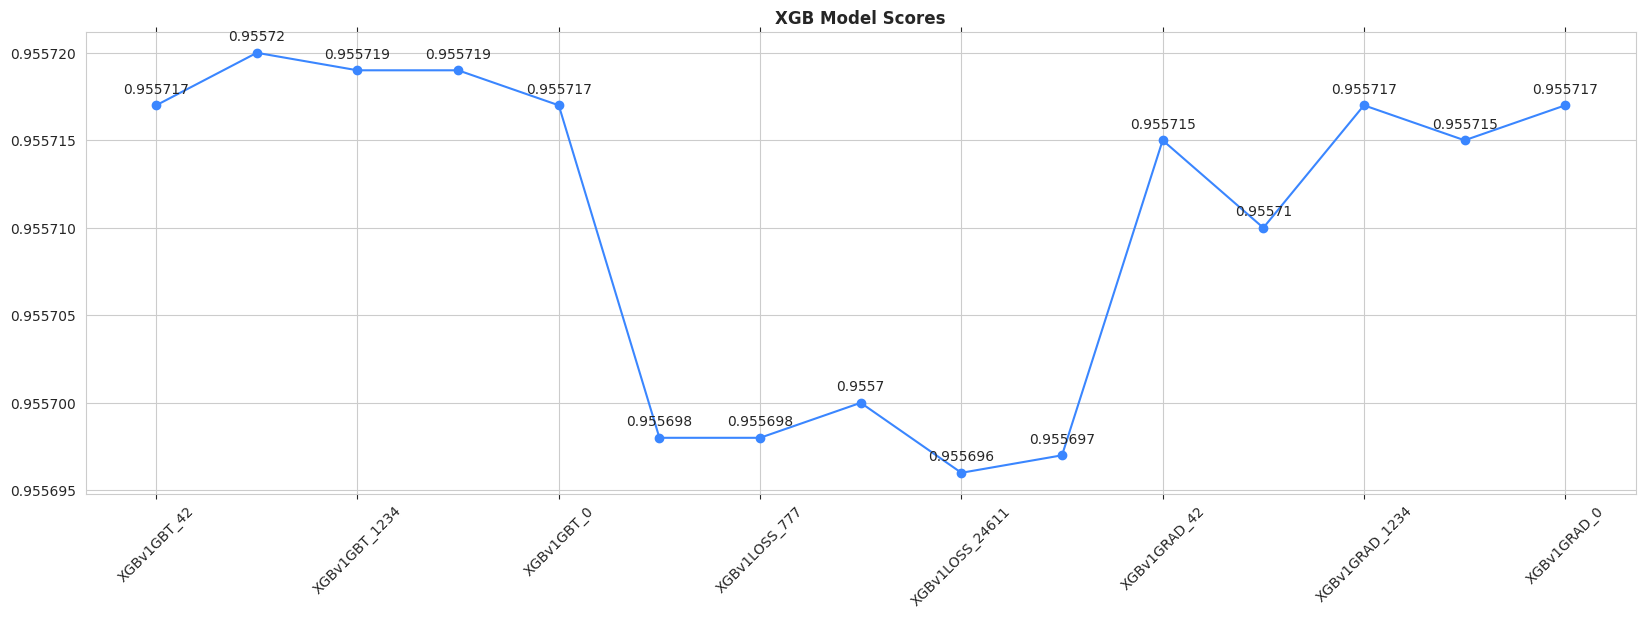

In [32]:
## -- Get Scores --
all_model_scores = {}

for k, v in all_model_predictions.items():
    for x, y in v.items():
        if x == 'score':
            # print(k, y)
            all_model_scores[k] = y


plt.figure(figsize=(20, 6))
pd.Series(all_model_scores).plot(marker='o')
plt.title('XGB Model Scores', fontweight='semibold')
for i, score in enumerate(all_model_scores.values()):
    plt.text(float(i), score+1e-6, score, ha='center', va='center_baseline')

plt.tick_params('x', rotation=45, reset=True)
plt.show()

In [33]:
## -- Get oof outputs --
all_model_oof = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'oof_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_oof = pd.concat([all_model_oof, pd.DataFrame({n: y})], axis=1)

all_model_oof.to_parquet(f"oof_{version_name}_models.parquet", index=False)
all_model_oof.head()

XGBv1GBT_42_955717  XGBv1GBT_777_95572  XGBv1GBT_1234_955719  \
0            0.997869            0.997953              0.997876   
1            0.008521            0.008534              0.008667   
2            0.009411            0.009442              0.009318   
3            0.051845            0.051200              0.052321   
4            0.998056            0.998090              0.998101   

   XGBv1GBT_24611_955719  XGBv1GBT_0_955717  XGBv1LOSS_4_42_955698  \
0               0.997884           0.997901               0.997323   
1               0.008611           0.008520               0.008718   
2               0.009286           0.009251               0.009378   
3               0.052623           0.053131               0.050235   
4               0.998107           0.998071               0.997269   

   XGBv1LOSS_777_955698  XGBv1LOSS_1234_9557  XGBv1LOSS_24611_955696  \
0              0.997308             0.997395                0.997420   
1              0.008758             0.008752                0.008436   
2              0.009364             0.009039                0.009229   
3              0.048879             0.048149                0.048697   
4              0.997412             0.997445                0.997712   

   XGBv1LOSS_0_955697  XGBv1GRAD_42_955715  XGBv1GRAD_777_95571  \
0            0.997371             0.997822             0.997891   
1            0.008829             0.008647             0.009058   
2            0.009034             0.009558             0.009314   
3            0.048637             0.051077             0.050192   
4            0.997438             0.998230             0.998200   

   XGBv1GRAD_1234_955717  XGBv1GRAD_24611_955715  XGBv1GRAD_0_955717  
0               0.997963                0.997926            0.997932  
1               0.008670                0.008705            0.008664  
2               0.009431                0.009189            0.009597  
3               0.050311                0.051398            0.050152  
4               0.998155                0.998084            0.998038

In [34]:
## -- Get test predictions --
all_model_test = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'test_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_test = pd.concat([all_model_test, pd.DataFrame({n: y})], axis=1)

all_model_test.to_parquet(f"test_{version_name}_models.parquet", index=False)
all_model_test.head()

XGBv1GBT_42_955717  XGBv1GBT_777_95572  XGBv1GBT_1234_955719  \
0            0.945144            0.945656              0.945265   
1            0.007377            0.007396              0.007386   
2            0.992114            0.992185              0.992150   
3            0.003603            0.003600              0.003596   
4            0.208748            0.208788              0.209054   

   XGBv1GBT_24611_955719  XGBv1GBT_0_955717  XGBv1LOSS_4_42_955698  \
0               0.945758           0.944958               0.945689   
1               0.007392           0.007370               0.007708   
2               0.992130           0.992084               0.991646   
3               0.003588           0.003570               0.003777   
4               0.208823           0.208567               0.213417   

   XGBv1LOSS_777_955698  XGBv1LOSS_1234_9557  XGBv1LOSS_24611_955696  \
0              0.945039             0.945178                0.944512   
1              0.007865             0.007808                0.007751   
2              0.991632             0.991821                0.991667   
3              0.003841             0.003855                0.003791   
4              0.214201             0.211041                0.212689   

   XGBv1LOSS_0_955697  XGBv1GRAD_42_955715  XGBv1GRAD_777_95571  \
0            0.945021             0.945078             0.944141   
1            0.007729             0.007567             0.007521   
2            0.991688             0.992358             0.992308   
3            0.003836             0.003588             0.003628   
4            0.212368             0.209124             0.210604   

   XGBv1GRAD_1234_955717  XGBv1GRAD_24611_955715  XGBv1GRAD_0_955717  
0               0.944356                0.944848            0.944372  
1               0.007541                0.007507            0.007529  
2               0.992340                0.992419            0.992292  
3               0.003652                0.003586            0.003641  
4               0.209626                0.210739            0.209449

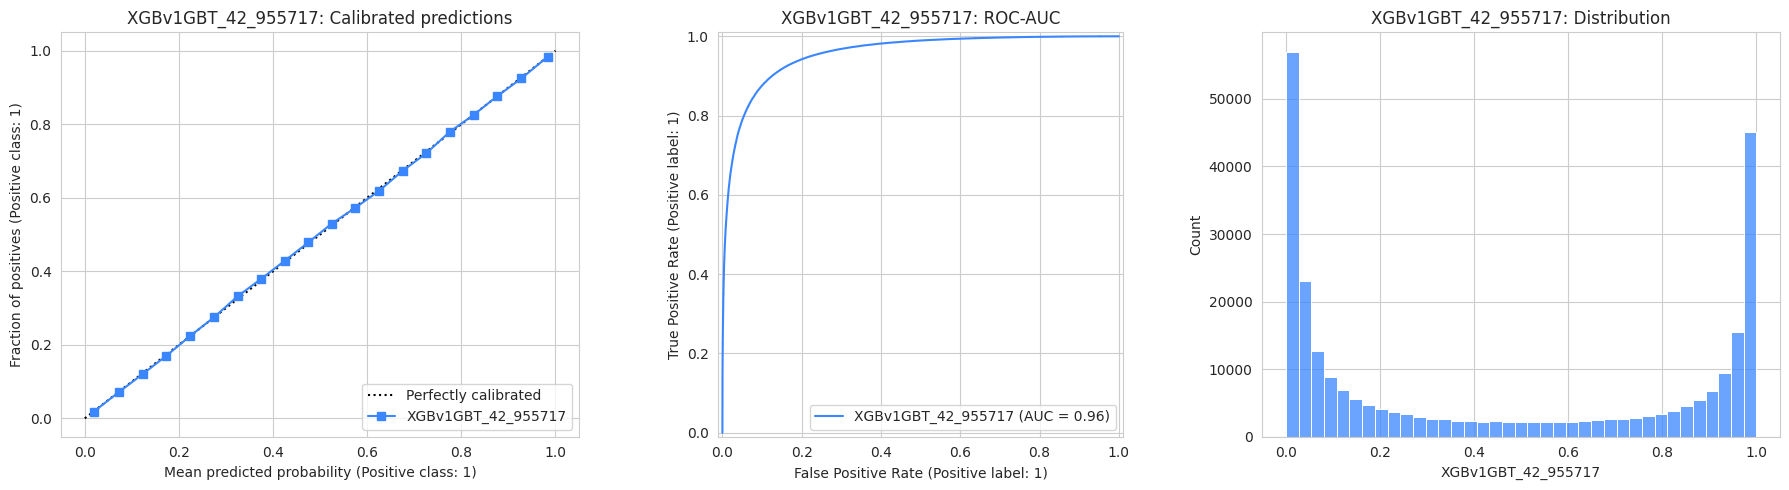

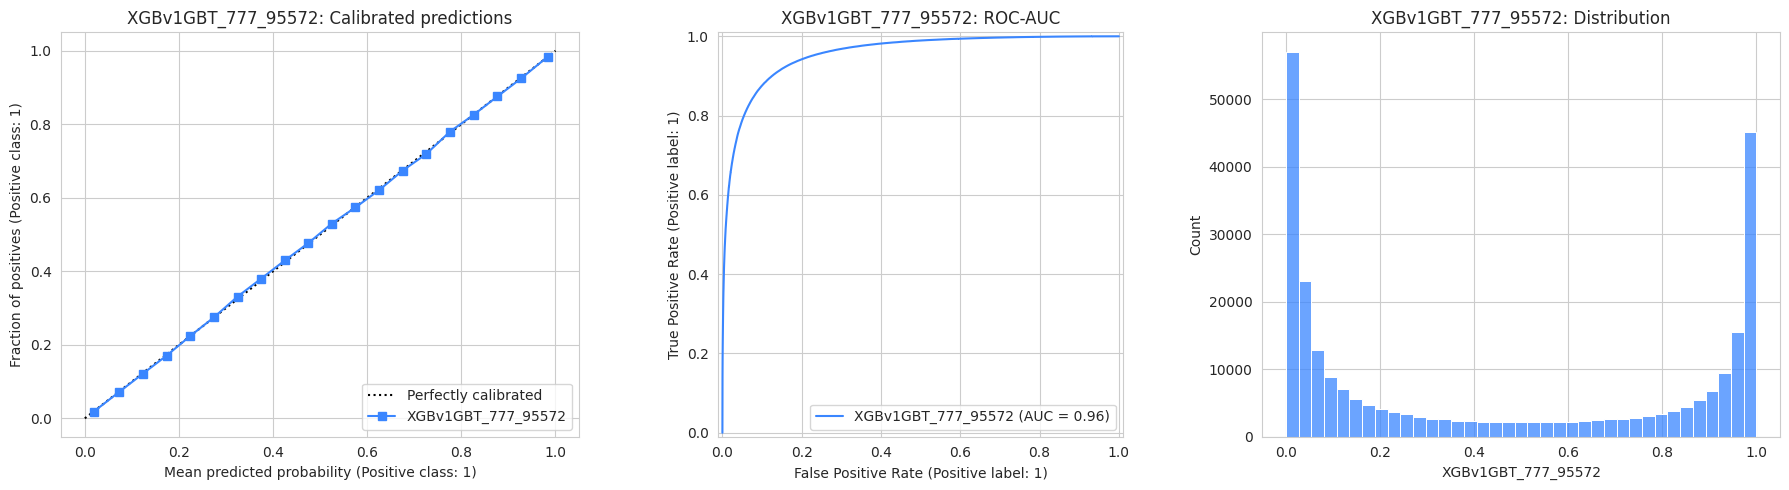

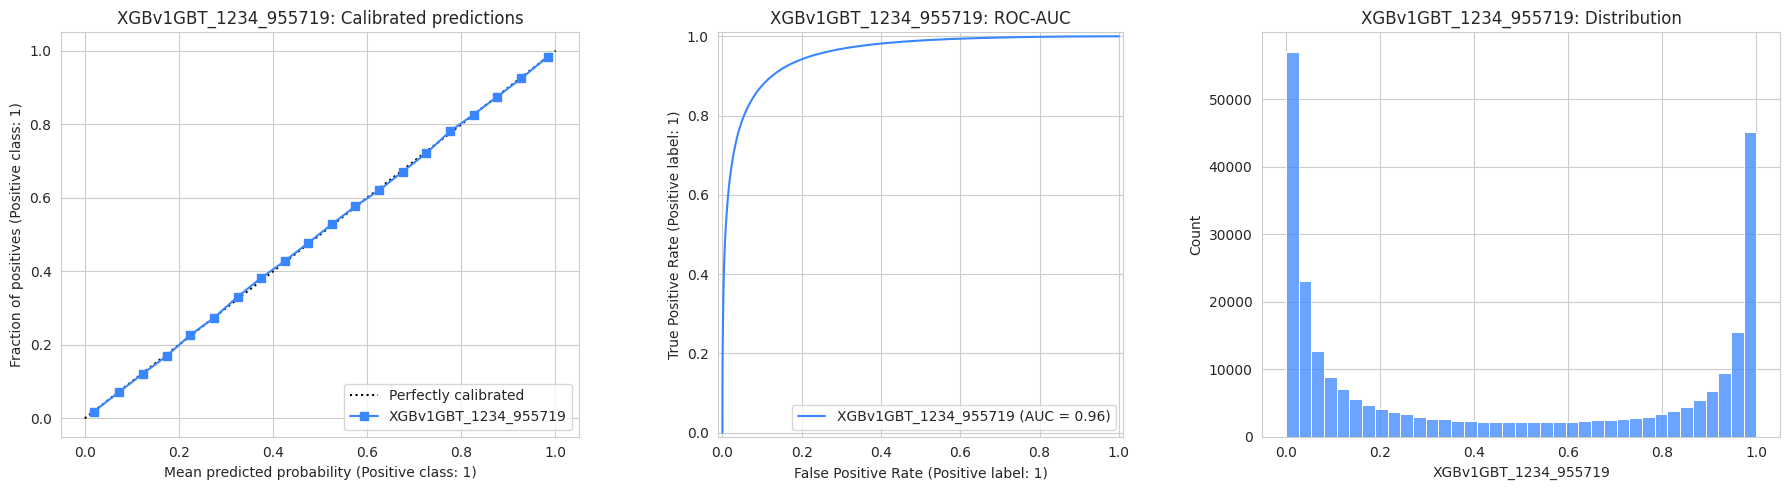

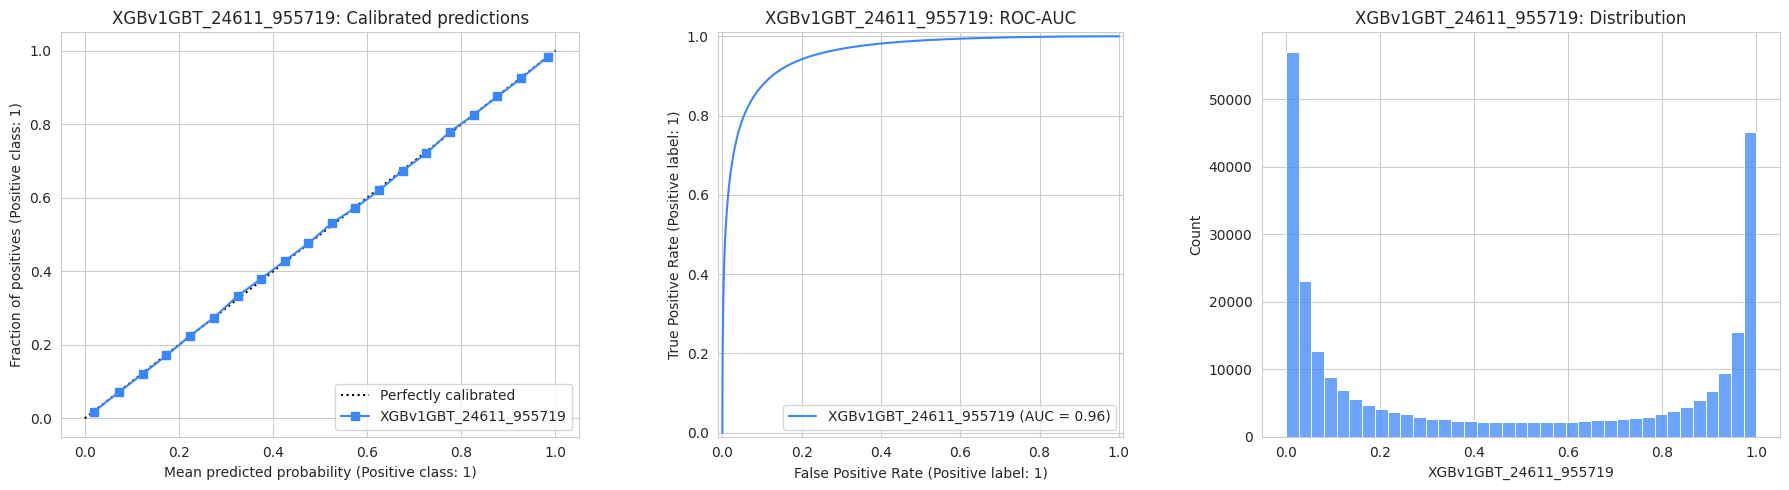

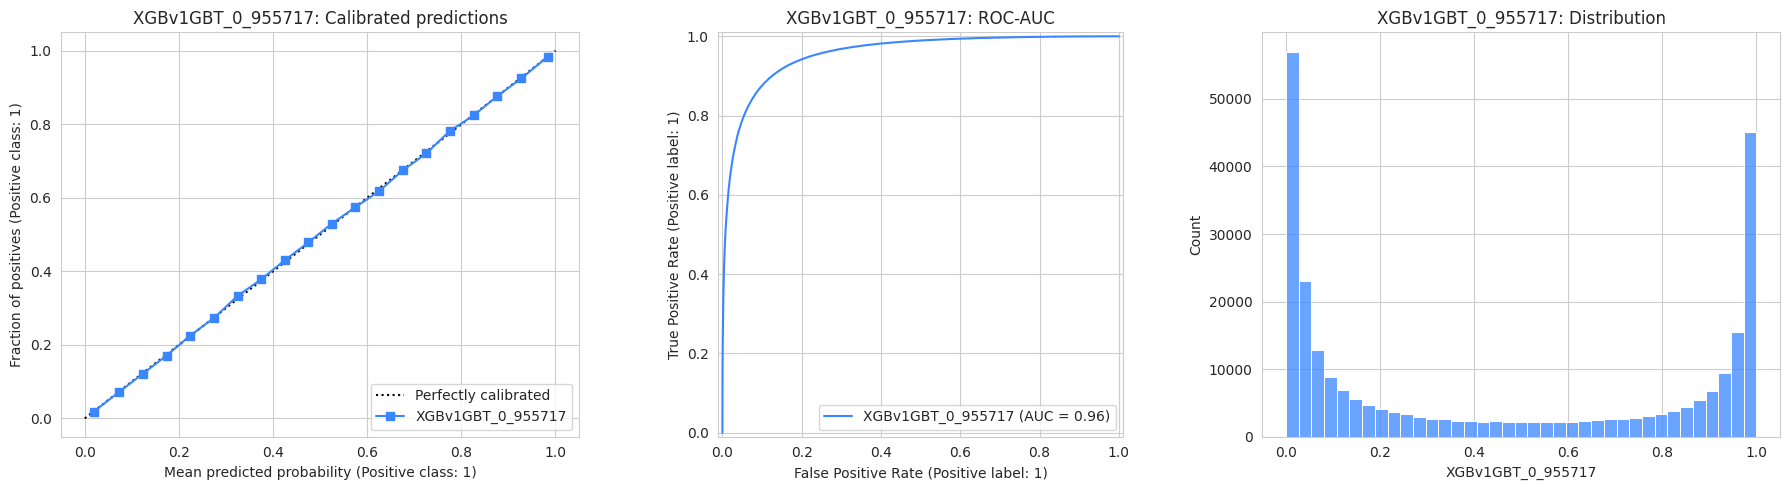

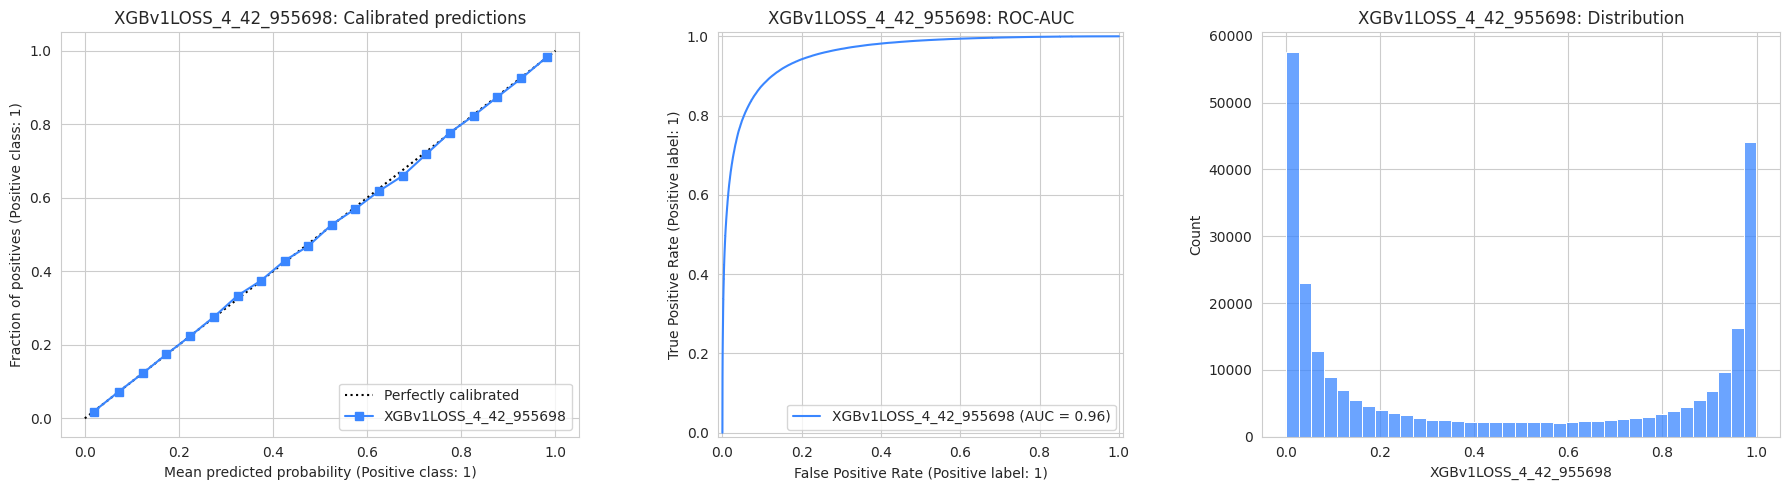

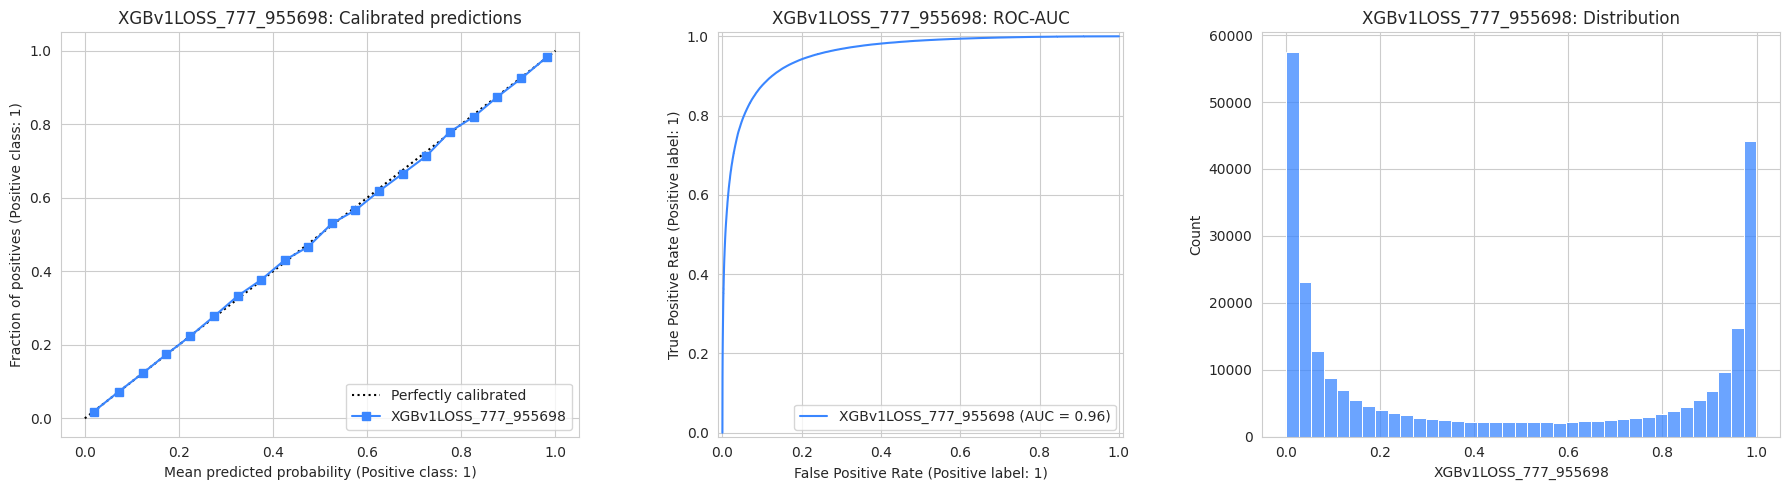

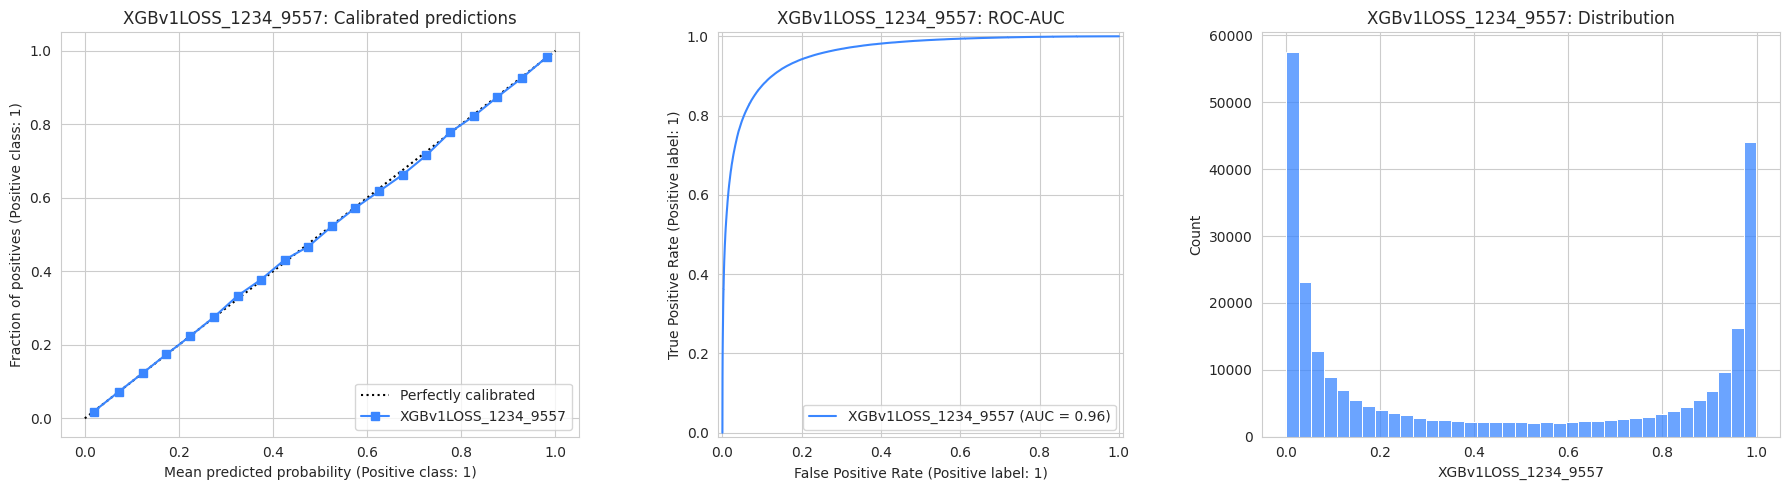

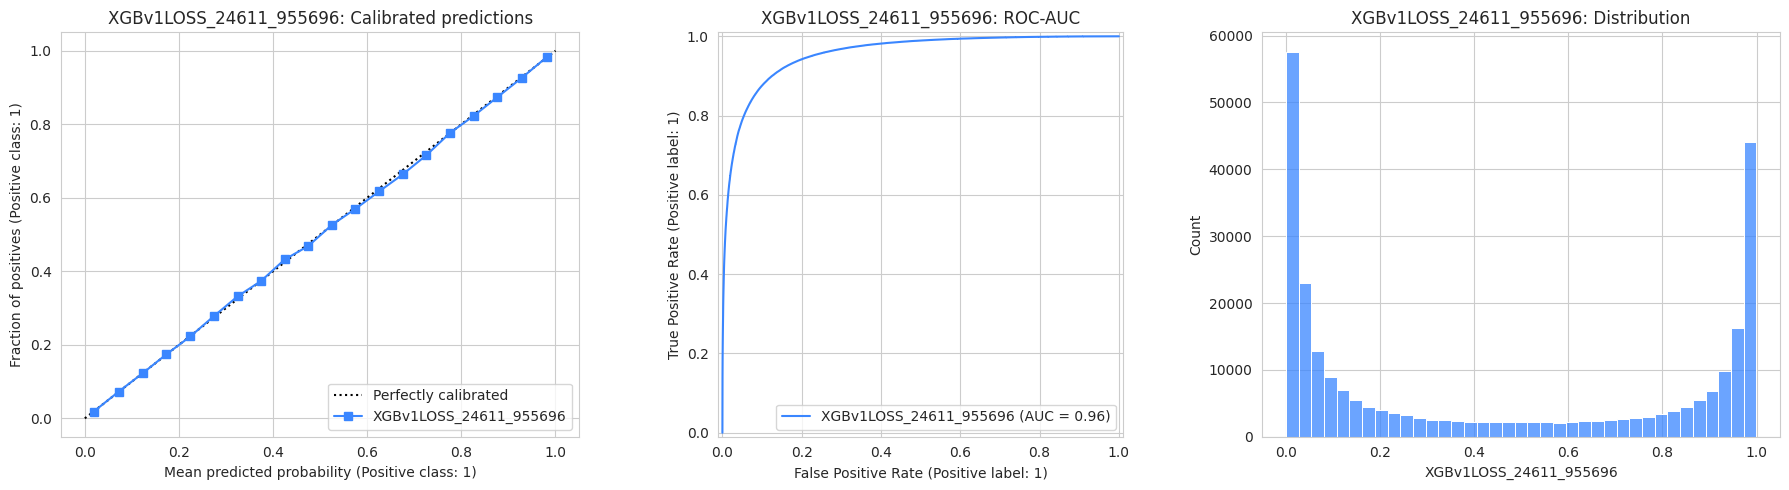

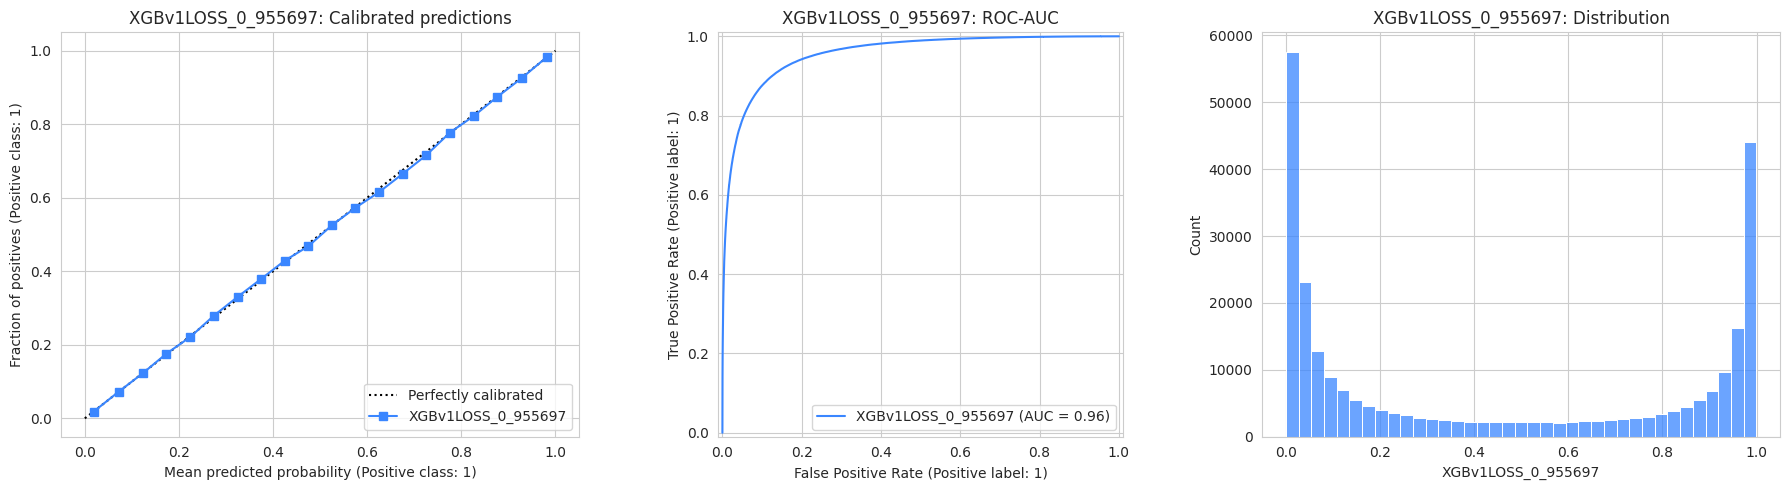

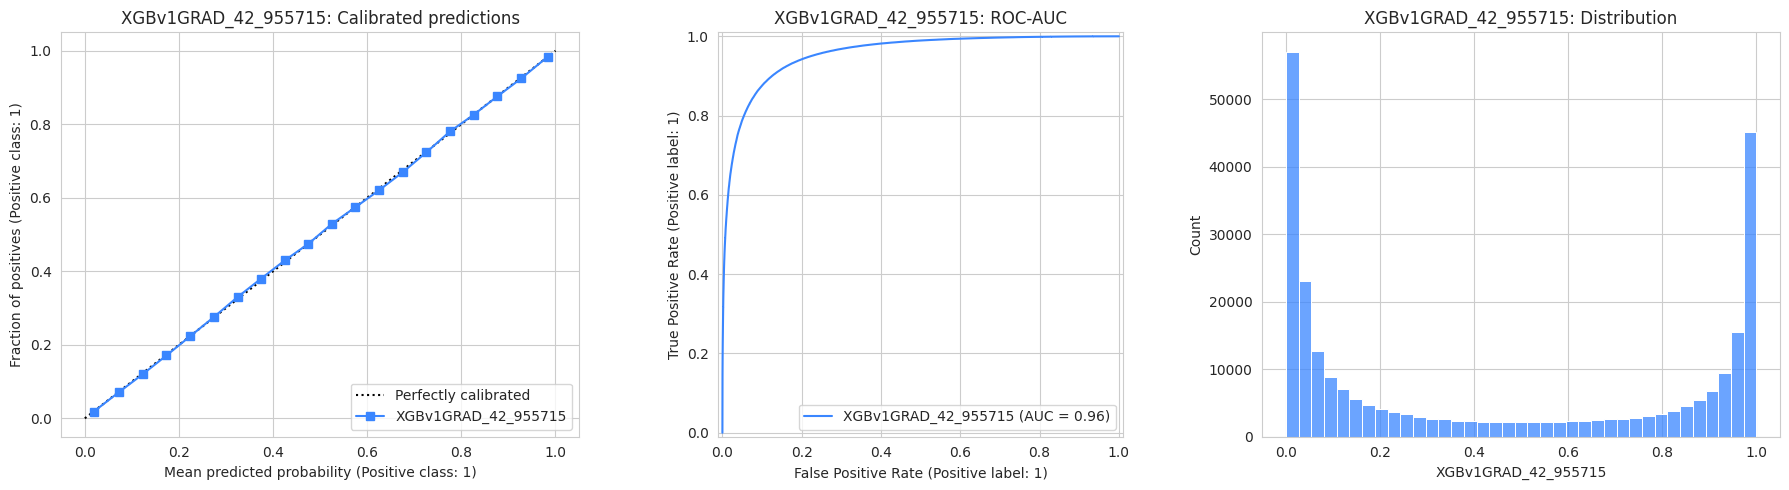

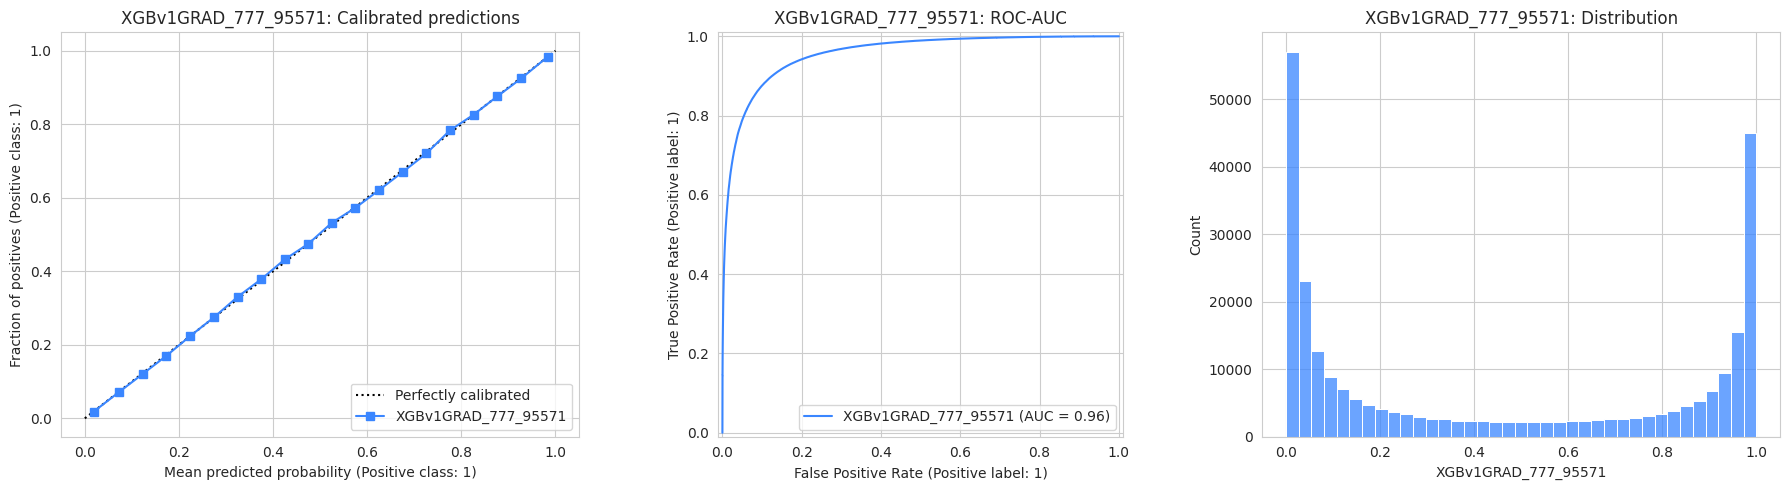

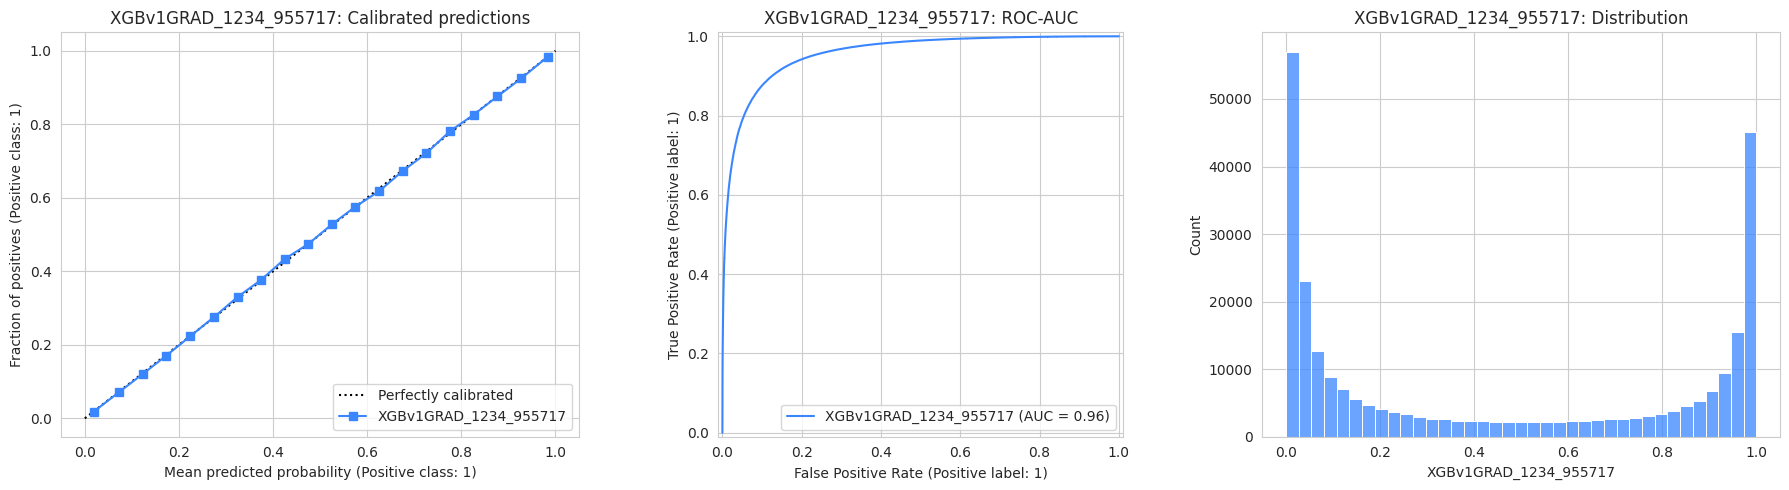

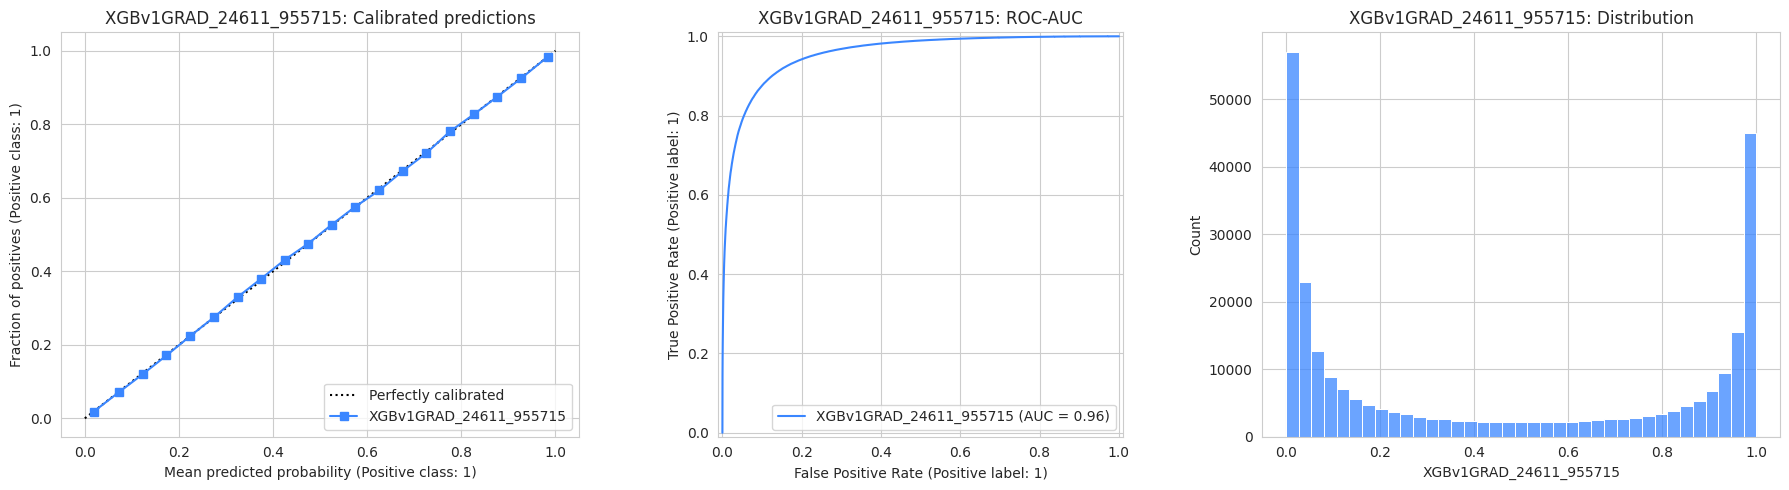

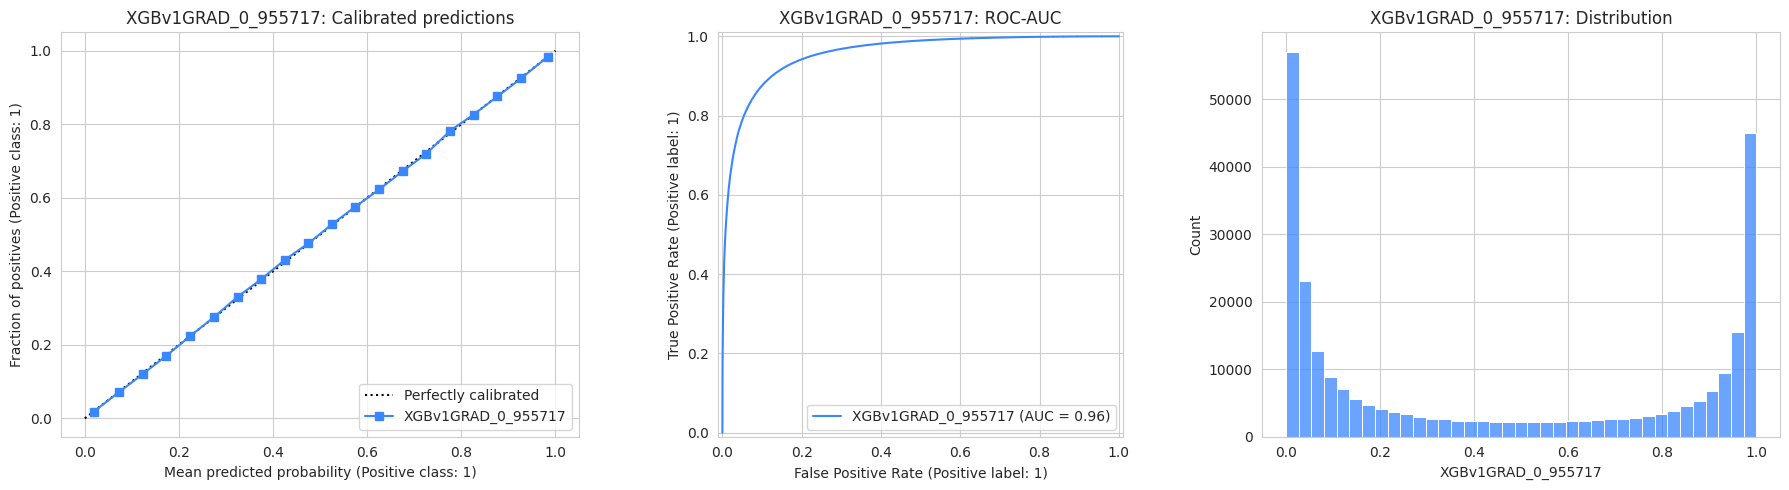

In [35]:
## -- PLOT MODEL PREDICTIONS --
for i, n in enumerate(all_model_test.columns):
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]
    
    CalibrationDisplay.from_predictions(train[TARGET], all_model_oof[n], n_bins=20, name=n, ax=axs[0])
    axs[0].set_title(f"{n}: Calibrated predictions")
    
    RocCurveDisplay.from_predictions(train[TARGET], all_model_oof[n], name=n, ax=axs[1])
    axs[1].set_title(f"{n}: ROC-AUC")
    # axs[1].grid(False)

    sns.histplot(all_model_test[n], ax=axs[2])
    axs[2].set_title(f"{n}: Distribution")
    
    plt.tight_layout()
    plt.show()
    print()

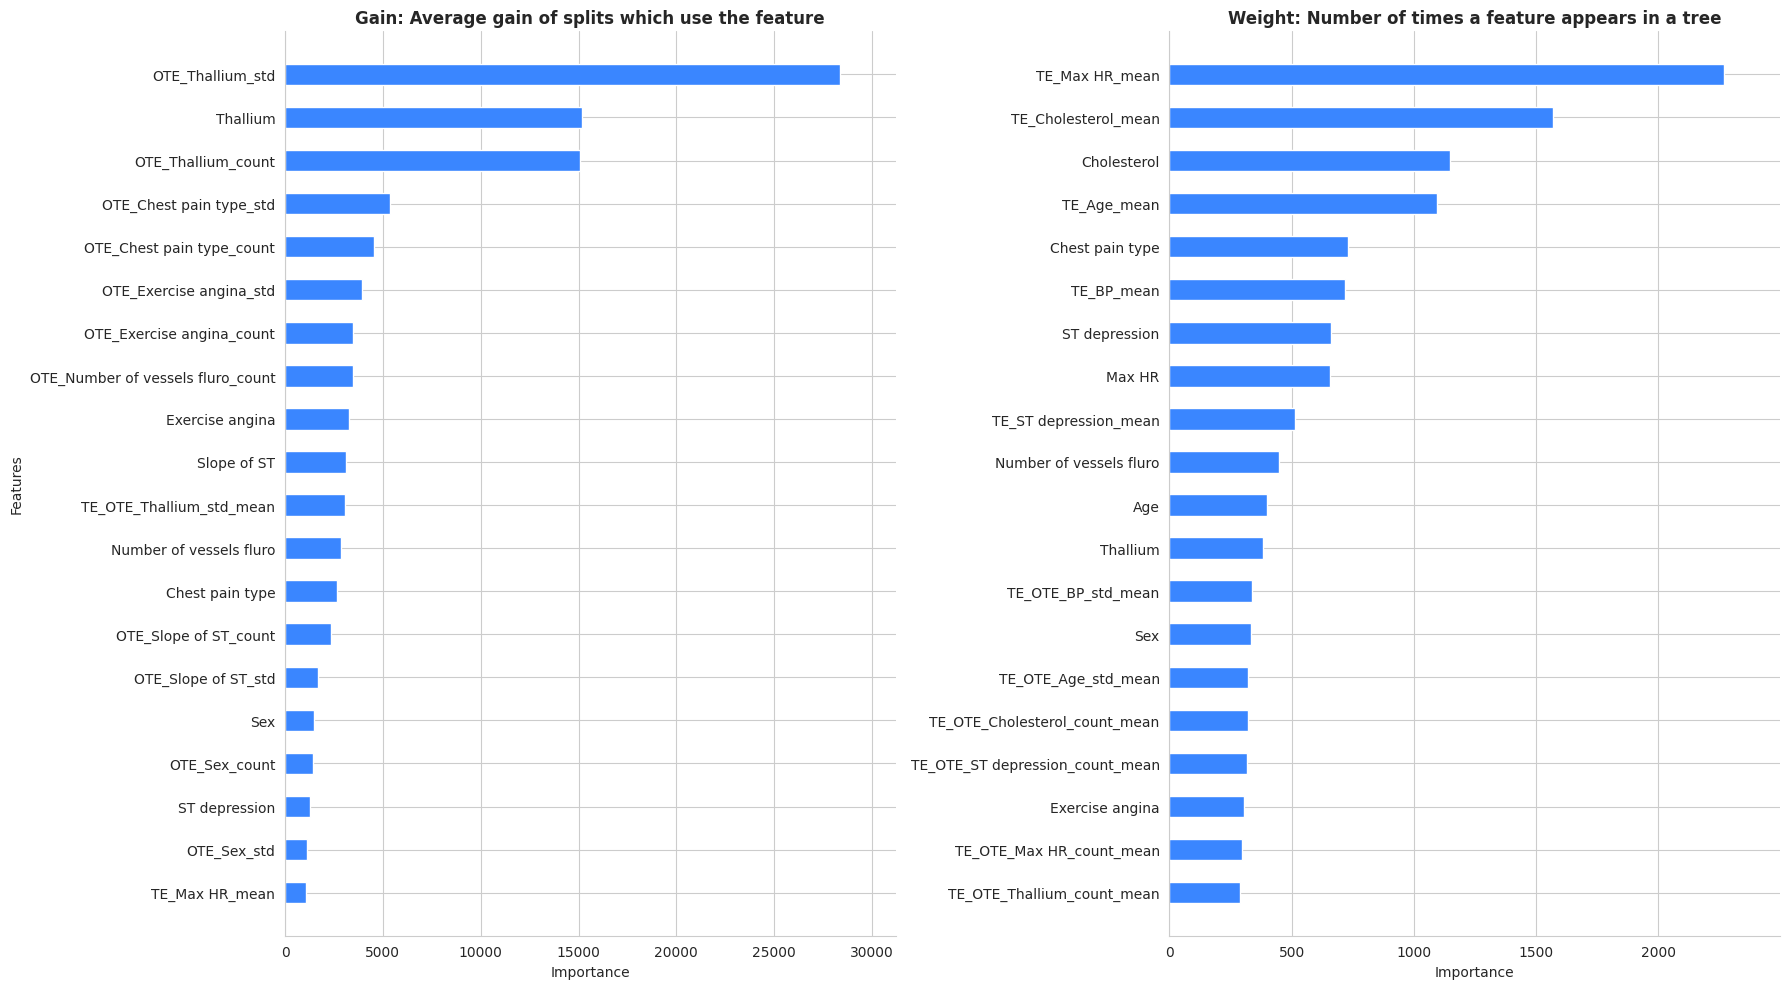

In [36]:
## -- Plot Feature Importances --
get_model = all_model_predictions[list(all_model_predictions.keys())[0]]

MAX = 20
_, axs = plt.subplots(1, 2, figsize=(18, 10))
xgb.plot_importance(
    get_model['model'],
    importance_type='gain',
    max_num_features=MAX,
    ax=axs[0], height=0.5, #grid=False,
    show_values=False,
)
axs[0].set_title('Gain: Average gain of splits which use the feature', fontweight='bold')

xgb.plot_importance(
    get_model['model'],
    importance_type='weight',
    max_num_features=MAX,
    ax=axs[1], height=0.5, #grid=False,
    show_values=False,
)
axs[1].set_title('Weight: Number of times a feature appears in a tree', fontweight='bold')
axs[1].set_ylabel('')

for ax in axs:
    ax.set_xlabel('Importance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.show()